In [1]:
"""
This is the code for PRESTO: Privacy Recommendation and Security Optimization tool.

Bayesian optimization is used to automatically select the best privacy mechanism and its optimal epsilon.
Top-3 Recommendations, Confidence Analysis, Performance Explanation, GPU Support, and Visualization.

Metrics Explanations:
- KS Statistic: measures the maximum difference between two cumulative distribution functions; desired value near 0.
- Jensen–Shannon Divergence (JSD): quantifies how two distributions diverge in bits; desired value near 0 bits.
- Pearson Correlation: indicates linear alignment between original and private data; desired value close to +1.
- Mean Utility-Privacy Score: negative root mean square error of privatization; desired to be as high as possible (closer to 0).
- Confidence Interval (CI) Width: range of the 95% confidence interval for the utility score; desired width to be small (e.g., <0.05).
- Reliability: ratio of mean utility score to CI width, reflecting consistency; desired to be high (e.g., >10).

Desired Metrics:
- Similarity Metrics:
    KS ≈ 0 (identical distributions)
    JSD ≈ 0 bits (minimal divergence)
    Pearson ≈ +1 (strong linear fidelity)
- Confidence Metrics:
    mean as high as possible (closer to 0, since we use negative RMSE)
    CI width small (e.g., <0.05 for stable performance)
- Performance Explanation:
    A small confidence interval (CI) width indicates consistent performance across evaluations.
    Reliability is computed as 1 / (RMSE × CI width); higher values (e.g., >10) suggest a reliable and stable privacy-utility trade-off.
"""

'\nThis is the code for PRESTO: Privacy Recommendation and Security Optimization tool.\n\nBayesian optimization is used to automatically select the best privacy mechanism and its optimal epsilon.\nTop-3 Recommendations, Confidence Analysis, Performance Explanation, GPU Support, and Visualization.\n\nMetrics Explanations:\n- KS Statistic: measures the maximum difference between two cumulative distribution functions; desired value near 0.\n- Jensen–Shannon Divergence (JSD): quantifies how two distributions diverge in bits; desired value near 0 bits.\n- Pearson Correlation: indicates linear alignment between original and private data; desired value close to +1.\n- Mean Utility-Privacy Score: negative root mean square error of privatization; desired to be as high as possible (closer to 0).\n- Confidence Interval (CI) Width: range of the 95% confidence interval for the utility score; desired width to be small (e.g., <0.05).\n- Reliability: ratio of mean utility score to CI width, reflecting

In [13]:
# Libraries used in the code.

# Installs the Bayesian Optimization library used for optimizing black-box functions
!pip install bayesian-optimization

# Imports the math module for mathematical operations like sqrt, log, etc.
import math

# PyTorch library for tensor computations and deep learning
import torch

# Standard library for generating random numbers
import random

# NumPy for efficient numerical computations and array handling
import numpy as np

# Seaborn for statistical data visualization (built on top of matplotlib)
import seaborn as sns

# Pandas for data manipulation and analysis; 're' for regular expressions
import pandas as pd, re

# SHA-256 hashing algorithm from hashlib for generating hash digests
from hashlib import sha256

# SciPy statistics module for statistical tests and distributions
from scipy import stats as st

# Mounts Google Drive in Google Colab to access external files
from google.colab import drive

# Matplotlib for plotting and visualizing data
import matplotlib.pyplot as plt

# KS test for comparing two distributions; Pearson correlation for measuring linear relationships
from scipy.stats import ks_2samp, pearsonr

# BayesianOptimization class for black-box function optimization using Bayesian inference
from bayes_opt import BayesianOptimization

# Jensen-Shannon distance for measuring similarity between two probability distributions
from scipy.spatial.distance import jensenshannon

In [14]:
# Fixed seed for reproducibility; 42 is a popular choice (reference to *The Hitchhiker's Guide to the Galaxy*)
SEED = 42

# Set the random seed for Python's built-in random module
random.seed(SEED)

# Set the seed for NumPy's random number generator
np.random.seed(SEED)

# Set the seed for PyTorch's random number generator (for CPU)
torch.manual_seed(SEED)


In [15]:
# Global device definition for GPU support.
# Selects GPU ('cuda') if available; otherwise falls back to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If running on a GPU, set the seed for all CUDA devices to ensure reproducibility
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

# Print the device being used (helpful for debugging and verification)
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Helper function to convert a PyTorch tensor to a flattened list via NumPy
def numpy_to_list(nd_array):
    """
    Converts a PyTorch tensor to a flattened Python list using NumPy.

    Args:
        nd_array (torch.Tensor): A PyTorch tensor (any shape, assumed to be on CPU or GPU).

    Returns:
        list: A flattened list of tensor values.
    """
    return nd_array.cpu().numpy().flatten().tolist()

# Converts input data to a PyTorch tensor if it's not already one; uses float32 dtype
def _to_tensor(data):
    """
    Ensures input is a PyTorch tensor. If it's not, converts it using float32 precision.

    Args:
        data (list, np.ndarray, or torch.Tensor): The input data to convert.

    Returns:
        torch.Tensor: The input as a torch tensor with dtype=float32.
    """
    if not torch.is_tensor(data):
        return torch.as_tensor(data, dtype=torch.float32)
    return data

# Flattens a nested list or array and returns both the flattened list and the original shape
def type_checking_and_return_lists(domain):
    """
    Converts a list, numpy array, or tensor to a flattened list and captures its original shape.

    Args:
        domain (list, np.ndarray, or torch.Tensor): Input data to be flattened.

    Returns:
        tuple:
            - list: Flattened data as a list.
            - tuple: Original shape of the input data.
    """
    arr = np.array(domain)
    return arr.flatten().tolist(), arr.shape

# Converts a flat list back to the original structure and type (Tensor or list) based on `domain`
def type_checking_return_actual_dtype(domain, data_list, shape):
    """
    Reconstructs the original structure and type of a dataset from a flat list.

    Args:
        domain (list, np.ndarray, or torch.Tensor): Original data used to infer target type and shape.
        data_list (list): Flattened list of privatized or transformed values.
        shape (tuple): Original shape to reshape the flat list into.

    Returns:
        torch.Tensor or list: Data reshaped and converted back to match the original input type.
    """
    arr = np.array(data_list).reshape(shape)
    if isinstance(domain, torch.Tensor):
        return torch.from_numpy(arr).to(dtype=domain.dtype, device=domain.device)
    return arr.tolist()

In [17]:
# Privacy Preservation Functions.
# This part can be extended and new algorithms can be added when needed.

# --- Classical Differential Privacy Mechanisms ---

# Adds Gaussian noise to data for (ε, δ)-differential privacy.
def applyDPGaussian(domain, sensitivity=1, delta=1e-5, epsilon=1, gamma=1):
    data, shape = type_checking_and_return_lists(domain)
    sigma = np.sqrt(sensitivity * np.log(1.25 / delta)) * gamma / epsilon
    privatized = np.array(data) + np.random.normal(0, sigma, size=len(data))
    return type_checking_return_actual_dtype(domain, privatized.tolist(), shape)

# Adds symmetric exponential noise (via signs) for ε-differential privacy.
def applyDPExponential(domain, sensitivity=1, epsilon=1, gamma=1.0):
    data, shape = type_checking_and_return_lists(domain)
    scale = sensitivity * gamma / epsilon
    noise = np.random.exponential(scale, size=len(data))
    signs = np.random.choice([-1, 1], size=len(data))
    priv = np.array(data) + noise * signs
    return type_checking_return_actual_dtype(domain, priv.tolist(), shape)

# Adds Laplace noise for ε-differential privacy.
def applyDPLaplace(domain, sensitivity=1, epsilon=1, gamma=1):
    data, shape = type_checking_and_return_lists(domain)
    noise = np.random.laplace(0, sensitivity * gamma / epsilon, size=len(data))
    privatized = np.array(data) + noise
    return type_checking_return_actual_dtype(domain, privatized.tolist(), shape)

# --- Sparse Vector Technique (Above-Threshold variant) ---

# Returns true value if it exceeds noisy threshold; otherwise returns random element.
def above_threshold_SVT(val, domain_list, T, epsilon):
    T_hat = T + np.random.laplace(0, 2/epsilon)
    nu_i = np.random.laplace(0, 4/epsilon)
    if val + nu_i >= T_hat:
        return val
    return random.choice(domain_list)

# Applies Above-Threshold Sparse Vector Technique across a dataset.
def applySVTAboveThreshold_full(domain, epsilon):
    """
    Applies Sparse Vector Technique (Above Threshold) across dataset using threshold=T=mean(domain).
    """
    data_list, shape = type_checking_and_return_lists(domain)
    T = np.mean(data_list)
    privatized = [above_threshold_SVT(val, data_list, T, epsilon) for val in data_list]
    return type_checking_return_actual_dtype(domain, privatized, shape)

# --- Percentile-based Privacy ---

# Zeroes out values below a chosen percentile.
def percentilePrivacy(domain, percentile=50):
    if not 0 <= percentile <= 100:
        raise ValueError("percentile must be between 0 and 100.")
    data, shape = type_checking_and_return_lists(domain)
    arr = np.array(data)
    threshold = np.percentile(arr, percentile)
    result = np.where(arr >= threshold, arr, 0)
    return type_checking_return_actual_dtype(domain, result.tolist(), shape)

# --- Fast Walsh–Hadamard Transform (used in Hadamard mechanisms) ---

# Performs in-place Fast Walsh–Hadamard Transform on a power-of-two tensor.
def fwht(x: torch.Tensor) -> torch.Tensor:
    """Perform Fast Walsh–Hadamard Transform (length must be power of two)."""
    h = 1
    y = x.clone()
    n = y.numel()
    while h < n:
        for i in range(0, n, h * 2):
            for j in range(i, i + h):
                u = y[j]
                v = y[j + h]
                y[j]     = u + v
                y[j + h] = u - v
        h *= 2
    return y

# --- Sketching/Transform-based DP Mechanisms ---

# Builds a histogram with Laplace noise and returns estimated mean.
def count_mean_sketch(data, epsilon: float, bins: int = 10) -> torch.Tensor:
    """Histogram with Laplace noise, then mean estimation."""
    data = _to_tensor(data)
    min_val = float(data.min().item())
    max_val = float(data.max().item())
    counts = torch.histc(data, bins=bins, min=min_val, max=max_val)
    scale = 1.0 / epsilon
    noise = torch.distributions.Laplace(0, scale).sample(counts.size()).to(data.device)
    noisy = counts.float() + noise
    edges = torch.linspace(min_val, max_val, steps=bins+1, device=data.device)
    centers = (edges[:-1] + edges[1:]) / 2
    mean_est = (noisy * centers).sum() / noisy.sum()
    return torch.full_like(data, mean_est)

# Applies Laplace noise in the Hadamard transform domain for compressed DP.
def hadamard_mechanism(data, epsilon: float) -> torch.Tensor:
    """Add Laplace noise in the Hadamard transform domain."""
    data = _to_tensor(data)
    n = data.numel()
    m = 1 << ((n - 1).bit_length())  # next power of two
    x = torch.zeros(m, dtype=data.dtype, device=data.device)
    x[:n] = data
    y = fwht(x) / math.sqrt(m)
    scale = math.sqrt(m) / epsilon
    noise = torch.distributions.Laplace(0, scale).sample((m,)).to(data.device)
    y_noisy = y + noise
    x_noisy = fwht(y_noisy) / math.sqrt(m)
    return x_noisy[:n]

# Simplified randomized response for categorical (discrete) local-DP.
def hadamard_response(data, epsilon: float) -> torch.Tensor:
    """Local-DP via simplified randomized response over integer categories."""
    data = _to_tensor(data)
    d = int(data.max().item()) + 1
    p = math.exp(epsilon) / (math.exp(epsilon) + 1)
    flip = torch.bernoulli(torch.full(data.size(), p, device=data.device))
    rand = torch.randint(0, d, data.size(), device=data.device)
    return torch.where(flip.bool(), data.long(), rand)

# --- RAPPOR Mechanism (Bloom filter + randomization) ---

# Implements basic RAPPOR using a bloom filter + randomized response.
def rappor(data, epsilon: float, m: int = 16, k: int = 2) -> torch.Tensor:
    """Basic RAPPOR: Bloom filter + randomized response."""
    data = _to_tensor(data)
    n = data.numel()
    bloom = torch.zeros((n, m), dtype=torch.bool, device=data.device)
    for i in range(n):
        val = int(data[i].item())
        for j in range(k):
            h = int(sha256(f"{val}_{j}".encode()).hexdigest(), 16)
            bloom[i, h % m] = True
    p = math.exp(epsilon) / (math.exp(epsilon) + 1)
    q = 1.0 / (math.exp(epsilon) + 1)
    rnd = torch.rand((n, m), device=data.device)
    priv = torch.where(bloom, rnd < p, rnd < q)
    out = priv.int().sum(dim=1).float() / p
    return out

# --- Unified Dictionary for Privacy Mechanisms ---

# Returns a dictionary of supported noise mechanisms with standardized interfaces.
def get_noise_generators():
    return {
        "DP_Gaussian": lambda d, epsilon, **kw: applyDPGaussian(d, delta=kw.get('delta',1e-5), epsilon=epsilon, gamma=kw.get('gamma',1)),
        "DP_Exponential": lambda d, epsilon, **kw: applyDPExponential(d, sensitivity=kw.get('sensitivity',1), epsilon=epsilon, gamma=kw.get('gamma',1.0)),
        "DP_Laplace": lambda d, epsilon, **kw: applyDPLaplace(d, sensitivity=kw.get('sensitivity',1), epsilon=epsilon, gamma=kw.get('gamma',1)),
        "SVT_AboveThreshold": lambda d, epsilon, **kw: applySVTAboveThreshold_full(d, epsilon),
        "PercentilePrivacy": lambda d, epsilon, **kw: percentilePrivacy(d, percentile=kw.get('percentile',50)),
        'Count_Mean_Sketch': count_mean_sketch,
        'Hadamard_Mechanism': hadamard_mechanism,
        # 'Hadamard_Response': hadamard_response,  # (commented out; can be enabled if needed)
        'RAPPOR': rappor,
    }

In [18]:
# Instantiate the dictionary of available privacy-preserving noise mechanisms
NOISE_GENERATORS = get_noise_generators()

In [19]:
# Utility-Privacy Scoring.
# Computes the negative Root Mean Squared Error (RMSE) between original and privatized data.
# Higher (i.e., less negative) values indicate better utility (less distortion).

def calculate_utility_privacy_score(domain, key, epsilon, **params):
    # Convert original domain to flat list
    data_list, _ = type_checking_and_return_lists(domain)

    # Apply the selected privacy mechanism from NOISE_GENERATORS
    privatized = NOISE_GENERATORS[key](domain, **{**params, 'epsilon': epsilon})

    # Convert privatized output to flat list
    priv_list, _ = type_checking_and_return_lists(privatized)

    # Compute RMSE between original and privatized data
    rmse = np.sqrt(np.mean((np.array(data_list) - np.array(priv_list))**2))

    # Return negative RMSE (higher = better utility)
    return -rmse

In [20]:
# Confidence evaluation for DP algorithms using repeated utility measurements.
# Desired characteristics: low standard deviation and narrow confidence interval (e.g., CI width < 0.05),
# which indicate the algorithm's stability and repeatability under the given ε (privacy budget).

def evaluate_algorithm_confidence(domain, key, epsilon, n_evals=10, **params):
    # Run the utility score multiple times (abs(-RMSE) → RMSE)
    scores = [abs(calculate_utility_privacy_score(domain, key, epsilon, **params)) for _ in range(n_evals)]

    # Compute statistics over the scores
    mean = np.mean(scores)                      # Mean RMSE across trials
    std = np.std(scores, ddof=1)                # Sample standard deviation
    ci = 1.96 * std / np.sqrt(n_evals)          # 95% Confidence Interval (normal approx.)

    # Return rounded summary metrics and individual scores
    return {
        'mean': round(mean, 4),                 # Average RMSE
        'std': round(std, 4),                   # Standard deviation of RMSE
        'ci_lower': round(mean - ci, 4),        # Lower bound of 95% CI
        'ci_upper': round(mean + ci, 4),        # Upper bound of 95% CI
        'ci_width': round(2 * ci, 4),           # Total CI width
        'scores': [round(s, 4) for s in scores] # Individual RMSE scores (rounded)
    }

In [21]:
# Performance Explanation Metrics.
# These metrics help assess the **confidence** in a DP algorithm's performance.

# - A smaller confidence interval (CI) width indicates more consistent (stable) performance.
# - Reliability is defined as: 1 / (RMSE × CI width)
#     - It jointly measures accuracy (low RMSE) and stability (narrow CI).
#     - A score >10 is generally considered a good threshold for selecting robust mechanisms.

def performance_explanation_metrics(metrics):
    rmse = metrics['mean']
    width = metrics['ci_upper'] - metrics['ci_lower']

    # Reliability is undefined if RMSE or CI width is zero; assign ∞ in such cases
    if width > 0 and rmse > 0:
        reliability = round(1 / (rmse * width), 4)
    else:
        reliability = np.inf  # Ideal or degenerate case

    return {
        'mean_rmse': rmse,               # Central accuracy metric
        'ci_width': round(width, 4),     # Stability metric
        'reliability': reliability       # Combined performance-confidence score
    }

In [22]:
"""
    Identifies the top 3 DP mechanisms that offer the best tradeoff between accuracy (low RMSE)
    and privacy (low ε), while maintaining high reliability and stability.

    For each DP mechanism in NOISE_GENERATORS:
      1. Use Bayesian Optimization to find the optimal ε in [0.1, 5.0] that minimizes RMSE.
      2. Evaluate confidence metrics (mean RMSE, CI width, reliability) at that ε.
      3. Rank mechanisms by (mean_rmse, epsilon, ci_width).

    Parameters:
        domain (Tensor/list): The data to privatize.
        n_evals (int): Number of utility evaluations per ε (for averaging).
        init_points (int): Initial random samples for Bayesian optimization.
        n_iter (int): Number of optimization iterations.

    Returns:
        top3 (list of dict): The top 3 mechanisms sorted by effectiveness and stability.
"""
def recommend_top3(domain, n_evals=5, init_points=2, n_iter=5):
    results = []

    for key in NOISE_GENERATORS:
        # Objective: maximize negative RMSE (i.e., minimize RMSE)
        def target(epsilon):
            scores = [
                calculate_utility_privacy_score(domain, key, epsilon)
                for _ in range(n_evals)
            ]
            return float(np.mean(scores))  # Mean negative RMSE

        # Bayesian Optimization to find best ε in [0.1, 5.0]
        optimizer = BayesianOptimization(
            f=target,
            pbounds={'epsilon': (0.1, 5.0)},
            verbose=0,
            random_state=1
        )
        optimizer.maximize(init_points=init_points, n_iter=n_iter)
        best = optimizer.max

        # Extract best ε and evaluate confidence at that point
        eps_opt = best['params']['epsilon']
        conf    = evaluate_algorithm_confidence(domain, key, eps_opt)
        perf    = performance_explanation_metrics(conf)

        # Record performance metrics
        results.append({
            'algorithm':   key,
            'epsilon':     eps_opt,
            'mean_rmse':   perf['mean_rmse'],   # Accuracy
            'ci_width':    perf['ci_width'],    # Stability
            'reliability': perf['reliability'], # Confidence metric
            'score':       best['target']       # Optimization score (neg RMSE)
        })

    # Rank by: lower RMSE → lower ε → narrower CI
    ranked = sorted(
        results,
        key=lambda x: (x['mean_rmse'], x['epsilon'], x['ci_width'])
    )

    return ranked[:3]  # Return top 3 mechanisms

In [23]:
# Visualization utilities. Similarity: KS ≈0, JSD ≈0, Pearson ≈+1 desired.

def visualize_data(domain, title="Data Distribution"):
    arr = np.array(domain)
    plt.figure(figsize=(12,6))
    sns.histplot(arr, bins=30, kde=True, alpha=0.6)
    plt.title(title); plt.xlabel("Value"); plt.ylabel("Frequency"); plt.grid(alpha=0.3); plt.show()

def visualize_similarity(domain, key, epsilon, **params):
    """
    Computes similarity metrics between original and privatized data and
    displays three side-by-side plots:
      1) Histogram of original data
      2) Histogram of private data
      3) Bar chart of KS, JSD, Pearson

    Parameters:
    - domain   : list or array of original values
    - key      : name of the DP mechanism in NOISE_GENERATORS
    - epsilon  : privacy parameter
    - **params : any additional arguments for the noise function
    """
    # Generate private data
    priv = NOISE_GENERATORS[key](domain, epsilon, **params)

    # Convert to numpy arrays
    o = np.array(domain)
    p = np.array(priv)

    # Compute similarity metrics
    ks   = round(ks_2samp(o, p)[0], 4)
    hist_o, bins = np.histogram(o, bins=30, density=True)
    hist_p, _    = np.histogram(p, bins=bins, density=True)
    jsd  = round(jensenshannon(hist_o, hist_p, base=2) ** 2, 4)
    corr = round(pearsonr(o, p)[0], 4)
    metrics = {'KS': ks, 'JSD': jsd, 'Pearson': corr}

    # Create a 1x3 subplot layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Panel 1: Original data histogram
    sns.histplot(o, bins=30, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title("Original Data Distribution")
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("Density")
    axes[0].grid(alpha=0.3)

    # Panel 2: Private data histogram
    sns.histplot(p, bins=bins, kde=True, ax=axes[1], color='orange')
    axes[1].set_title(f"Private Data ({key}, ε={epsilon:.2f})")
    axes[1].set_xlabel("Value")
    axes[1].set_ylabel("Density")
    axes[1].grid(alpha=0.3)

    # Panel 3: Similarity metrics bar chart
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")
    axes[2].set_title("Similarity Metrics")
    axes[2].set_ylabel("Score")
    axes[2].set_ylim(0, 1)  # since KS, JSD, and Pearson are in [0,1]
    axes[2].grid(axis='y', alpha=0.3)

    plt.suptitle(f"Similarity Analysis: {key} (ε={epsilon:.4f})", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return metrics

# Visualize top-3 recommendations
def visualize_top3(recommendations):
    labels = [f"{r['algorithm']}\nε={r['epsilon']:.2f}\nmean={r['mean']:.2f}\nwidth={r['ci_width']:.2f}" for r in recommendations]
    scores = [r['score'] for r in recommendations]
    plt.figure(figsize=(8,6))
    plt.bar(labels, scores, capsize=5)
    plt.title("Top 3 Privacy Mechanism Recommendations")
    plt.ylabel("Mean Utility-Privacy Score")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Visualize confidence for top algorithm. Desired: narrow error bars indicating small CI.
def visualize_confidence(domain, key, epsilon, n_evals=10, **params):
    res = evaluate_algorithm_confidence(domain, key, epsilon, n_evals, **params)
    mean, lower, upper = res['mean'], res['ci_lower'], res['ci_upper']
    plt.figure(figsize=(6,4))
    plt.bar([key], [mean], yerr=[[mean-lower],[upper-mean]], capsize=5)
    plt.title(f"Confidence: {key} (ε={epsilon:.2f})")
    plt.ylabel("Mean Utility-Privacy Score"); plt.grid(alpha=0.3); plt.show()
    return res

# Confidence visualization for Top-3 Mechanisms.
def visualize_confidence_top3(domain, recommendations, n_evals=10):
    """
    Visualizes 95% confidence intervals for each algorithm in recommendations.
    """
    labels = []
    means = []
    error_lower = []
    error_upper = []
    for rec in recommendations:
        alg = rec['algorithm']
        eps = rec['epsilon']
        conf = evaluate_algorithm_confidence(domain, alg, eps, n_evals)
        labels.append(f"{alg} ε={eps:.2f}")
        means.append(conf['mean'])
        error_lower.append(conf['mean'] - conf['ci_lower'])
        error_upper.append(conf['ci_upper'] - conf['mean'])
    plt.figure(figsize=(8,6))
    plt.bar(labels, means, yerr=[error_lower, error_upper], capsize=5)
    plt.title("95% Confidence Intervals for Top-3 Mechanisms")
    plt.ylabel("Mean Utility-Privacy Score")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Combined overlay plot
def visualize_overlay_original_and_private(domain, top3):
    arr_orig = np.array(domain)
    plt.figure(figsize=(10,6))
    sns.kdeplot(arr_orig, label='Original', fill=False)
    for rec in top3:
        key, eps = rec['algorithm'], rec['epsilon']
        priv = NOISE_GENERATORS[key](domain, eps)
        arr_priv = np.array(priv)
        sns.kdeplot(arr_priv, label=f"{key} ε={eps:.4f}", fill=False)
    plt.title("Overlay: Original vs Top-3 Privatized Distributions")
    plt.xlabel("Value"); plt.ylabel("Density"); plt.legend(); plt.grid(alpha=0.3); plt.show()

In [24]:
# Recomendation the best algorithms for privacy, reliability and similary for given epsilon.

def recommend_best_algorithms(
    data: torch.Tensor,
    epsilon: float,
    get_noise_generators,
    calculate_utility_privacy_score,
    evaluate_algorithm_confidence,
    performance_explanation_metrics
):
    """
    Returns the algorithms with:
      1) Maximum similarity (Pearson) between original & privatized data
      2) Maximum reliability (mean RMSE / CI width) at given ε
      3) Maximum privacy strength (mean absolute noise)
    Also plots, side-by-side, the original vs privatized distributions for each of these three.
    """
    # Ensure data is a CPU tensor
    if not torch.is_tensor(data):
        data = torch.as_tensor(data, dtype=torch.float32)
    data = data.to('cpu')
    orig_np = data.numpy()

    noise_gens = get_noise_generators()
    best_sim = ("", -1.0)
    best_rel = ("", -1.0)
    best_priv = ("", -1.0)

    # Identify top algorithms
    for algo, fn in noise_gens.items():
        # Generate private data
        private = fn(data, epsilon)
        if not torch.is_tensor(private):
            private = torch.as_tensor(private, dtype=data.dtype)
        priv_np = private.cpu().numpy()

        # 1) Similarity (Pearson)
        sim, _ = pearsonr(orig_np, priv_np)
        if sim > best_sim[1]:
            best_sim = (algo, round(sim, 4))

        # 2) Reliability (evaluate at this ε)
        conf = evaluate_algorithm_confidence(data, algo, epsilon)
        perf = performance_explanation_metrics(conf)
        rel = perf["reliability"]
        if rel > best_rel[1]:
            best_rel = (algo, round(rel, 4))

        # 3) Privacy strength (mean absolute noise)
        priv_strength = float(torch.mean((data - private).abs()).item())
        if priv_strength > best_priv[1]:
            best_priv = (algo, round(priv_strength, 4))

    # Gather the three best
    winners = {
        "max_similarity":  {"algorithm": best_sim[0], "score": best_sim[1]},
        "max_reliability": {"algorithm": best_rel[0], "score": best_rel[1]},
        "max_privacy":     {"algorithm": best_priv[0], "score": best_priv[1]},
    }

    # Plot original vs. private distributions side-by-side
    plt.figure(figsize=(18, 5))
    for idx, (key, info) in enumerate(winners.items(), start=1):
        algo = info["algorithm"]
        fn = noise_gens[algo]
        private = fn(data, epsilon)
        if not torch.is_tensor(private):
            private = torch.as_tensor(private, dtype=data.dtype)
        priv_np = private.cpu().numpy()

        ax = plt.subplot(1, 3, idx)
        sns.histplot(orig_np, bins=30, kde=True, color='skyblue', label="Original", ax=ax)
        sns.histplot(priv_np, bins=30, kde=True, color='orange', label=f"Private ({algo})", ax=ax)
        ax.set_title(f"{key.replace('_', ' ').title()}\n{algo} (ε={epsilon:.2f})", fontsize=12)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)

    plt.suptitle(f"Original vs. Private Distributions (ε={epsilon:.2f})", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return winners

In [ ]:
## Usecases:

In [15]:
# Synthetic data generation.

def generate_dataset() -> dict:
    """
    Generates a dictionary of more realistic datasets with varying properties and sizes.
    """
    datasets = {}
    # 1) Energy: base consumption: sinusoidal daily pattern + trend + noise
    hours = np.arange(0, 168)
    daily_pattern = 2.0 * np.sin(2 * np.pi * hours / 24)
    trend = 0.01 * hours
    noise = np.random.normal(0, 0.3, size=hours.shape)
    consumption = 5.0 + daily_pattern + trend + noise
    datasets["Energy (Hourly)"] = torch.tensor(consumption, dtype=torch.float32) # Convert to PyTorch tensor

    # 2) Finance: heavy-tailed log-normal (10k points)
    datasets["Finance (Log-Normal)"] = torch.exp(
        torch.normal(mean=3.5, std=1.2, size=(10000,), device=device)
    )
    # 3) IoT Sensor: temperature readings with daily cycle + noise (7d × 24h = 168)
    hours = torch.arange(0, 168, device=device)
    daily = 10 * torch.sin(2 * np.pi * hours / 24)
    trend = 0.01 * hours
    noise = torch.randn(168, device=device) * 0.5
    datasets["Sensor Temp (Hourly)"] = 20.0 + daily + trend + noise

    # 4) Medical: heart rate minute-resolution (24h = 1440 points)
    minutes = torch.arange(0, 1440, device=device)
    circadian = 15 * torch.sin(2 * np.pi * minutes / 1440)
    hr_noise = torch.randn(1440, device=device) * 2
    datasets["Heart Rate (Min)"] = 70.0 + circadian + hr_noise

    # 5) Web Traffic: Poisson-like bursty arrivals (5k points)
    lam = torch.linspace(5, 20, steps=5000, device=device)
    datasets["Web Hits (5k)"] = torch.poisson(lam)

    # 6) Mixed categorical/numerical: small domain + noise (2k points)
    cat = torch.randint(0, 5, (2000,), device=device)
    num = torch.randn(2000, device=device) * 3 + 10
    # interleave so that code paths for categorical get exercised
    datasets["Cat+Num"] = torch.stack([cat.float(), num], dim=1).view(-1)

    return datasets

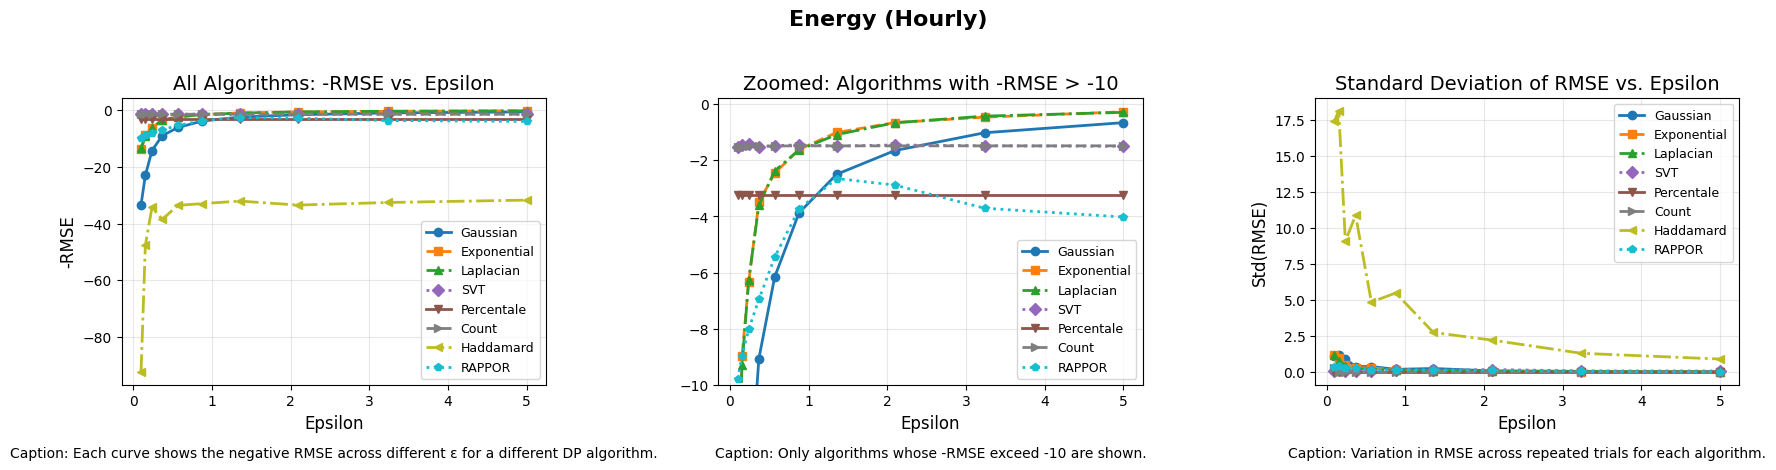

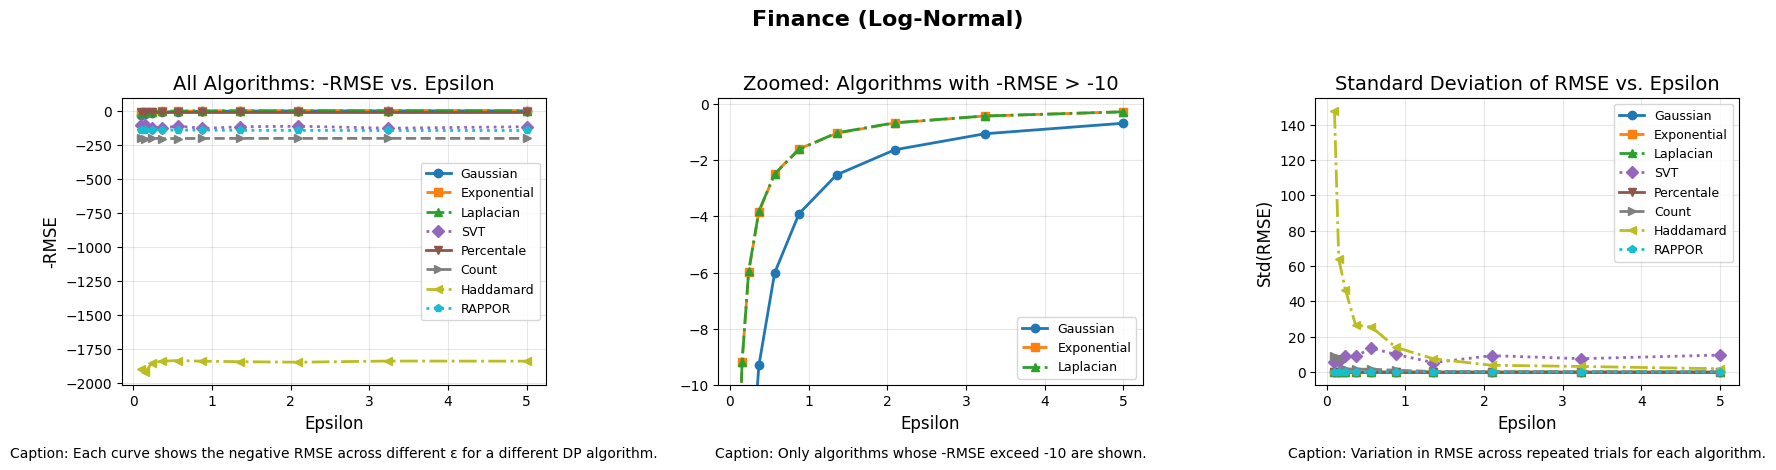

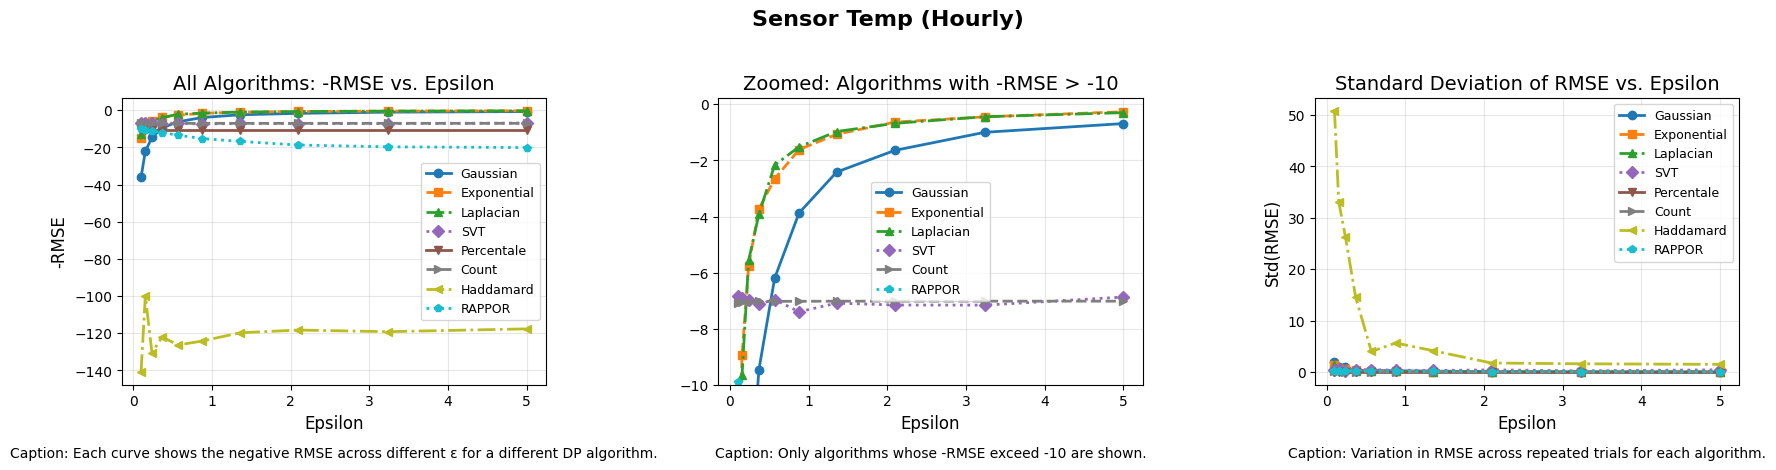

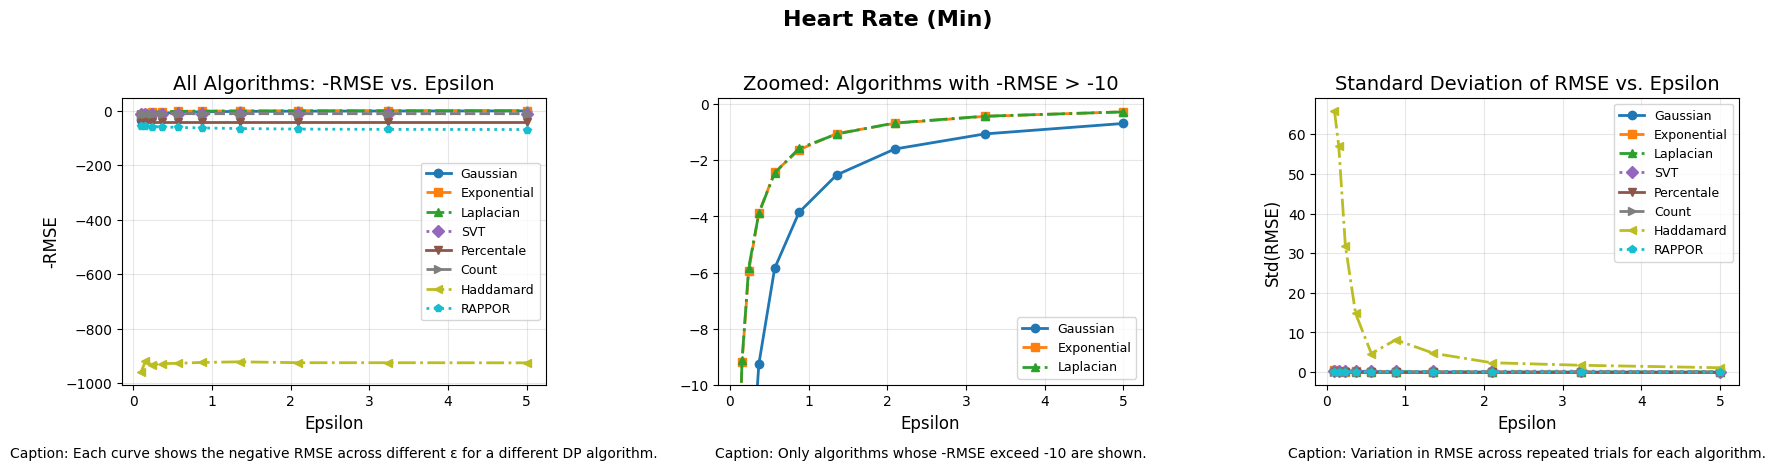

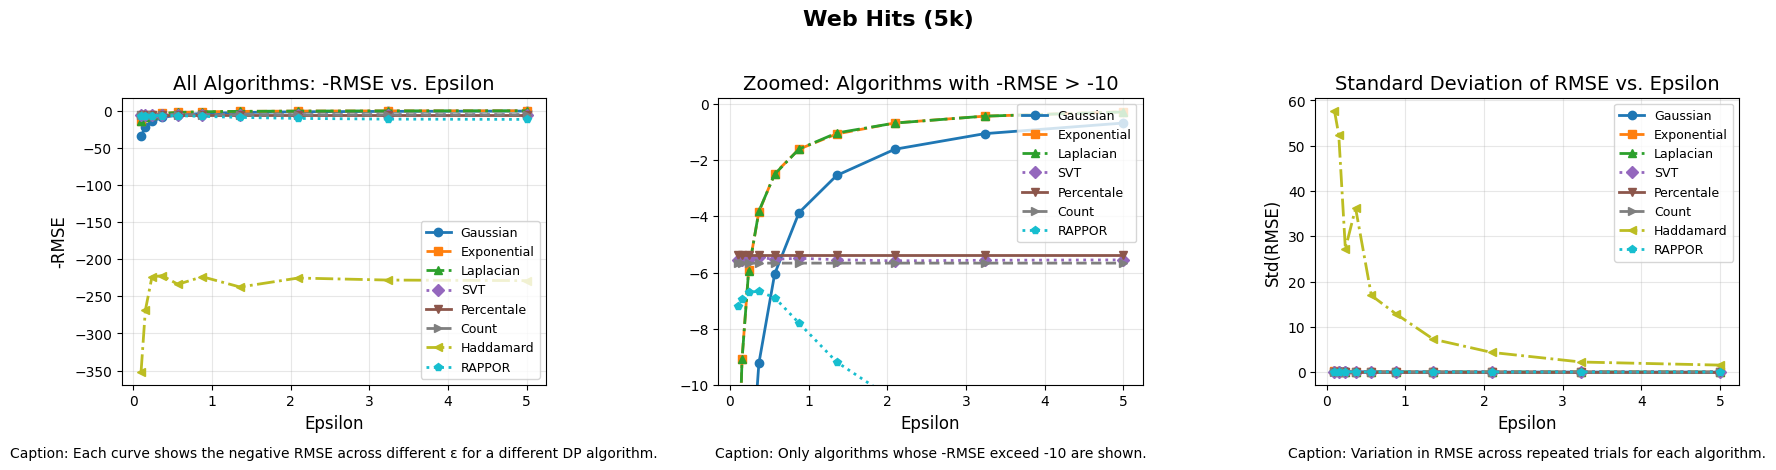

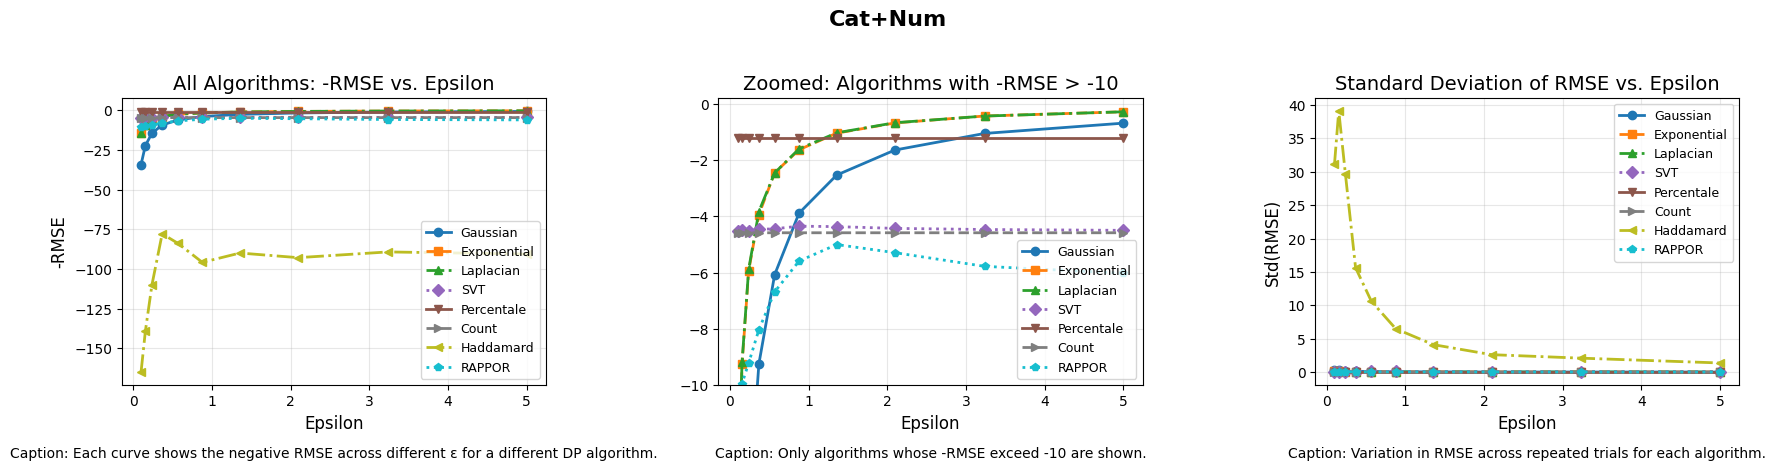

In [25]:
colormap = plt.get_cmap('tab10')

num_colors = len(NOISE_GENERATORS)
color_positions = np.linspace(0, 1, num_colors)
colors = colormap(color_positions)

dp_names = ['Gaussian', 'Exponential', 'Laplacian', 'SVT', 'Percentale', 'Count', 'Haddamard', 'RAPPOR']

def ranking_compute(domain, n_evals=3, init_points=2, n_iter=5):
    # this code evaluates estimated RMSE for a given dataset (domain) for varying noise generators and epsilon
    epsilon_ = np.logspace(np.log10(.1),np.log10(5),10)
    mean_neg_rmse = np.zeros((len(NOISE_GENERATORS),epsilon_.shape[0]))
    std_rmse = np.zeros((len(NOISE_GENERATORS),epsilon_.shape[0]))
    mean_rmse = np.zeros((len(NOISE_GENERATORS),epsilon_.shape[0]))
    results = []

    for i,key in enumerate(NOISE_GENERATORS): # vary noise generator
        def target(x_epsilon):
            return float(np.mean([calculate_utility_privacy_score(domain, key, x_epsilon) for _ in range(n_evals)]))
        for j,epsilon in enumerate(epsilon_): # vary epsilon
            mean_neg_rmse[i,j] = target(epsilon)
            conf = evaluate_algorithm_confidence(domain, key, epsilon)

            mean_rmse[i,j] = conf['mean']
            std_rmse[i,j] = conf['std']

            perf = performance_explanation_metrics(conf)
            results.append({
                'algorithm': key,
                'epsilon': epsilon,
                'mean_neg_rmse': mean_neg_rmse[i,j],
                **perf
        })

    return epsilon_, mean_neg_rmse, mean_rmse, std_rmse, results # sorted(results, key=lambda x: (x['mean_rmse'], -x['ci_width']), reverse=True)[:3]

def ranking_plot(x, y, ym, ys, colors, data_name, dp_names):
    """
    Plots three panels side by side with captions:
      1) All algorithms’ -RMSE curves
      2) Zoomed subset: only algorithms where -RMSE > -10
      3) Std(RMSE) curves

    Parameters:
    - x         : 1D array of epsilon values (M,)
    - y         : 2D array of -RMSE (N_algos, M)
    - ym        : unused placeholder (kept for API)
    - ys        : 2D array of std(RMSE) (N_algos, M)
    - colors    : array‐like of shape (N_algos, 3) or list of color specs
    - data_name : figure title
    - dp_names  : list of algorithm names (length N_algos)
    """
    N = y.shape[0]
    linestyles = ['-', '--', '-.', ':'] * ((N // 4) + 1)
    markers    = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', '*'] * ((N // 10) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    fig.suptitle(data_name, fontsize=16, weight='bold')

    # Panel 1: all -RMSE curves
    ax1 = axes[0]
    for i in range(N):
        ax1.plot(
            x, y[i],
            label=dp_names[i],
            color=colors[i],
            linestyle=linestyles[i],
            marker=markers[i],
            linewidth=2,
            markersize=6
        )
    ax1.set_xlabel("Epsilon", fontsize=12)
    ax1.set_ylabel("-RMSE", fontsize=12)
    ax1.grid(alpha=0.3)
    ax1.legend(loc='best', fontsize=9)
    ax1.set_title("All Algorithms: -RMSE vs. Epsilon", fontsize=14)
    ax1.text(
        0.5, -0.25,
        "Caption: Each curve shows the negative RMSE across different ε for a different DP algorithm.",
        transform=ax1.transAxes, ha='center', fontsize=10
    )

    # Identify algorithms where max(-RMSE) > -10
    indices_zoom = [i for i in range(N) if np.max(y[i]) > -10]

    # Panel 2: zoomed subset (-RMSE > -10)
    ax2 = axes[1]
    y_upper = np.max(y) + 0.5
    for i in indices_zoom:
        ax2.plot(
            x, y[i],
            label=dp_names[i],
            color=colors[i],
            linestyle=linestyles[i],
            marker=markers[i],
            linewidth=2,
            markersize=6
        )
    ax2.set_ylim(-10, y_upper)
    ax2.set_xlabel("Epsilon", fontsize=12)
    ax2.grid(alpha=0.3)
    ax2.legend([dp_names[i] for i in indices_zoom], fontsize=9, loc='best')
    ax2.set_title("Zoomed: Algorithms with -RMSE > -10", fontsize=14)
    ax2.text(
        0.5, -0.25,
        "Caption: Only algorithms whose -RMSE exceed -10 are shown.",
        transform=ax2.transAxes, ha='center', fontsize=10
    )

    # Panel 3: Std(RMSE) curves
    ax3 = axes[2]
    for i in range(N):
        ax3.plot(
            x, ys[i],
            label=dp_names[i],
            color=colors[i],
            linestyle=linestyles[i],
            marker=markers[i],
            linewidth=2,
            markersize=6
        )
    ax3.set_xlabel("Epsilon", fontsize=12)
    ax3.set_ylabel("Std(RMSE)", fontsize=12)
    ax3.grid(alpha=0.3)
    ax3.legend(loc='best', fontsize=9)
    ax3.set_title("Standard Deviation of RMSE vs. Epsilon", fontsize=14)
    ax3.text(
        0.5, -0.25,
        "Caption: Variation in RMSE across repeated trials for each algorithm.",
        transform=ax3.transAxes, ha='center', fontsize=10
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

dataset = generate_dataset()
data_iter = iter(dataset.items())

for i in range(len(dataset)):
    name, tensor = next(data_iter)
    domain = tensor.tolist()
    epsilon_, mean_neg_rmse, mean_rmse, std_rmse, results = ranking_compute(domain)
    ranking_plot(epsilon_,mean_neg_rmse, mean_rmse, std_rmse, colors,name, dp_names)


=== Dataset: Energy (Hourly) ===
Top-3 Recommendations:
  DP_Exponential: ε=3.6282, mean_rmse=0.3788, ci_width=0.0326, reliability=80.98
  DP_Laplace: ε=3.6269, mean_rmse=0.3932, ci_width=0.0507, reliability=50.16
  DP_Gaussian: ε=3.6296, mean_rmse=0.9529, ci_width=0.0657, reliability=15.97

Similarity Metrics for Top-3:


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


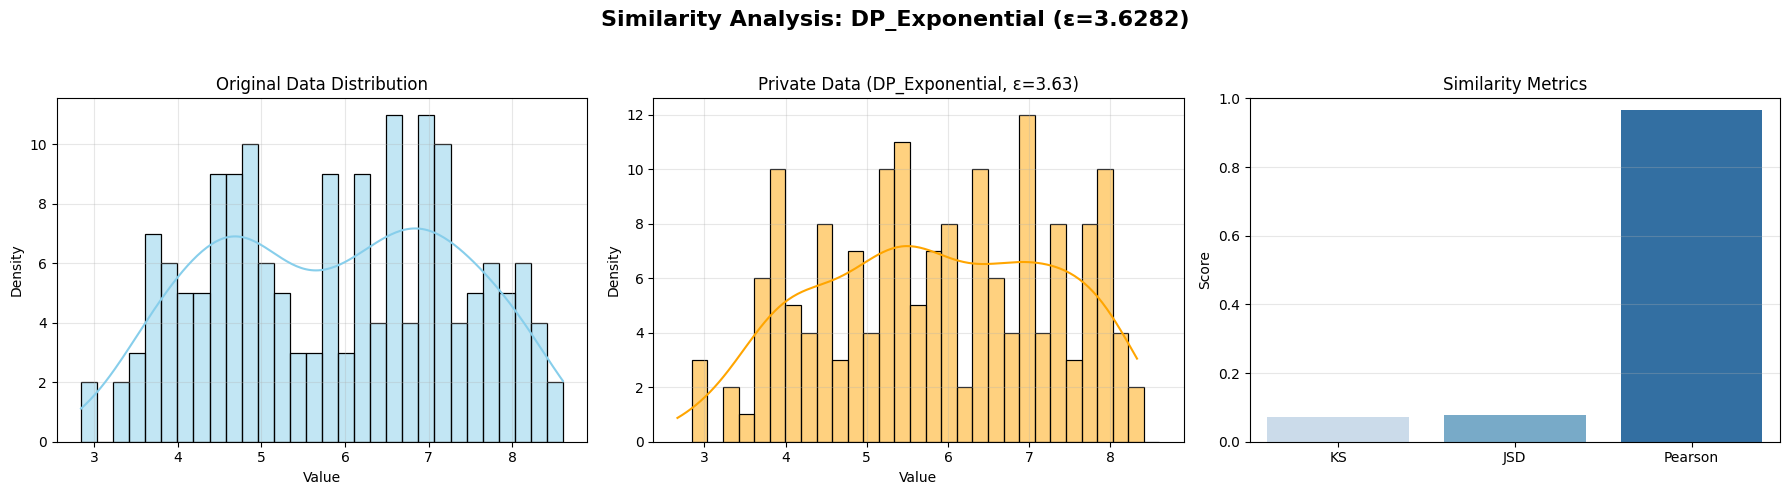

  DP_Exponential: KS=0.0714, JSD=0.0767, Pearson=0.9649


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


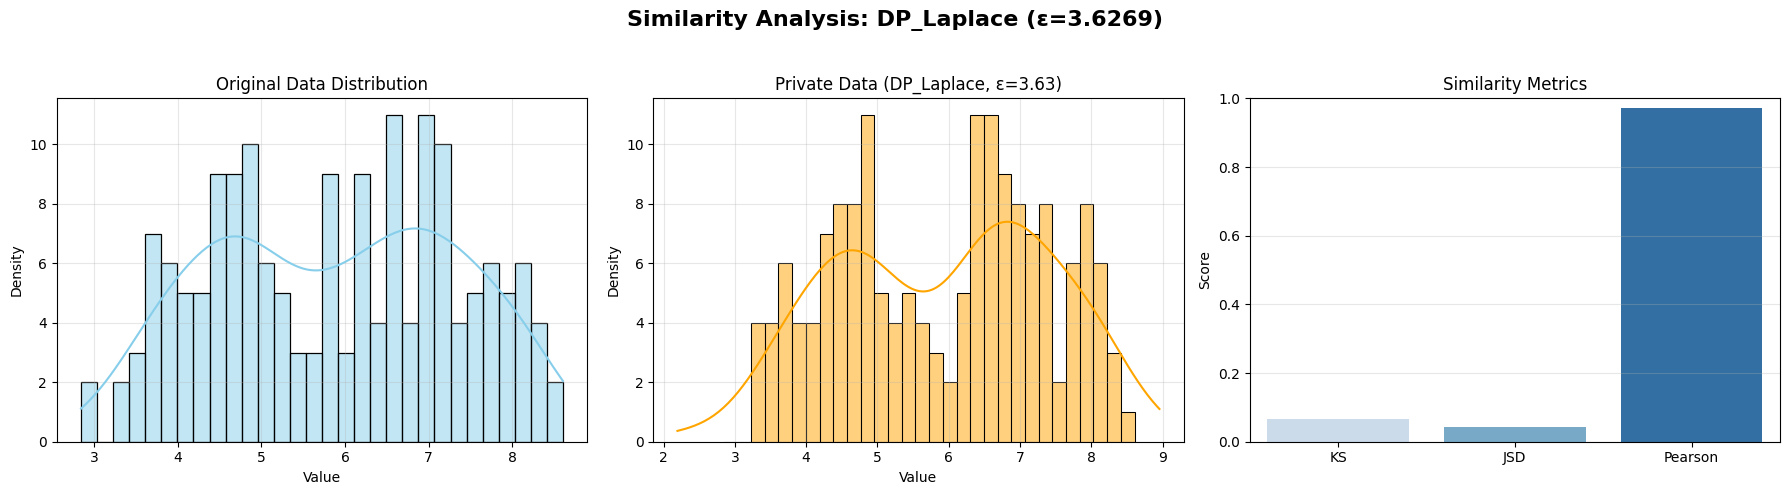

  DP_Laplace: KS=0.0655, JSD=0.0440, Pearson=0.9716


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


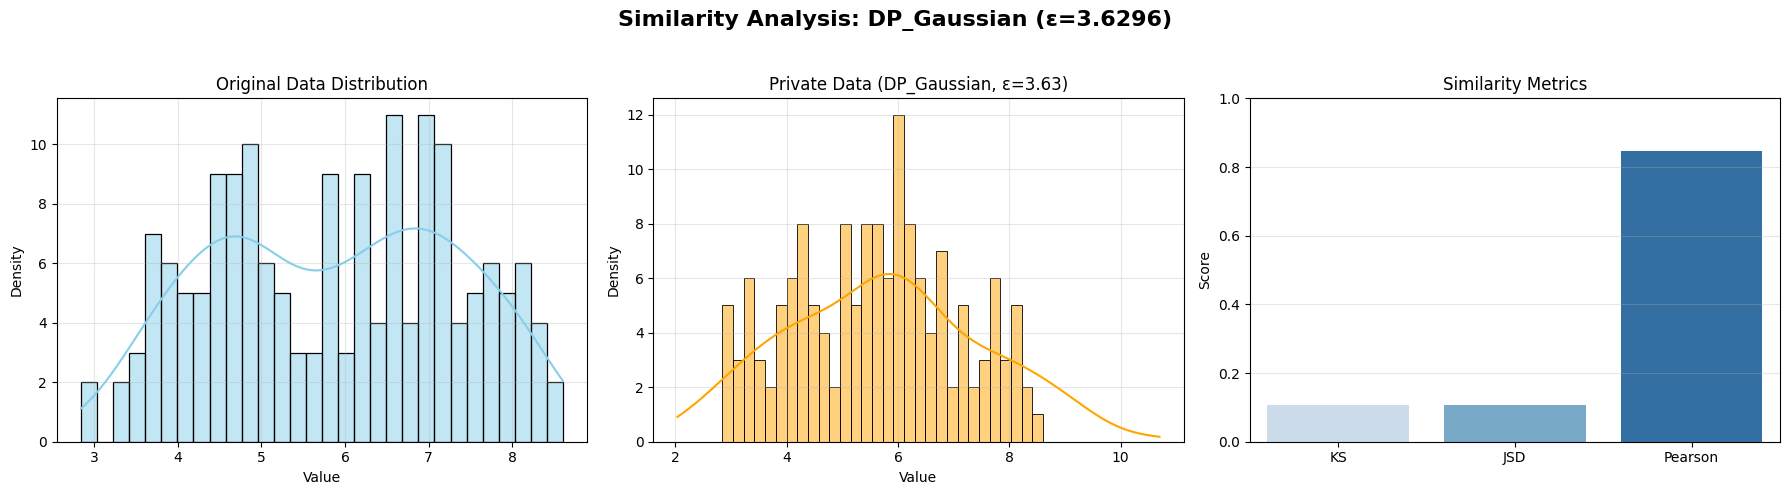

  DP_Gaussian: KS=0.1071, JSD=0.1062, Pearson=0.8455

Confidence Metrics for Top-3:
  DP_Exponential: mean_rmse=0.3924, ci_width=0.0510, reliability=49.97
  DP_Laplace: mean_rmse=0.4015, ci_width=0.0349, reliability=71.37
  DP_Gaussian: mean_rmse=0.9524, ci_width=0.0512, reliability=20.51


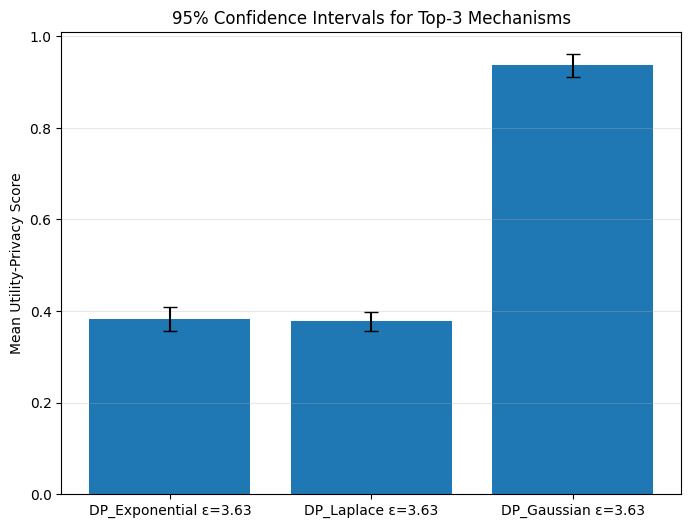

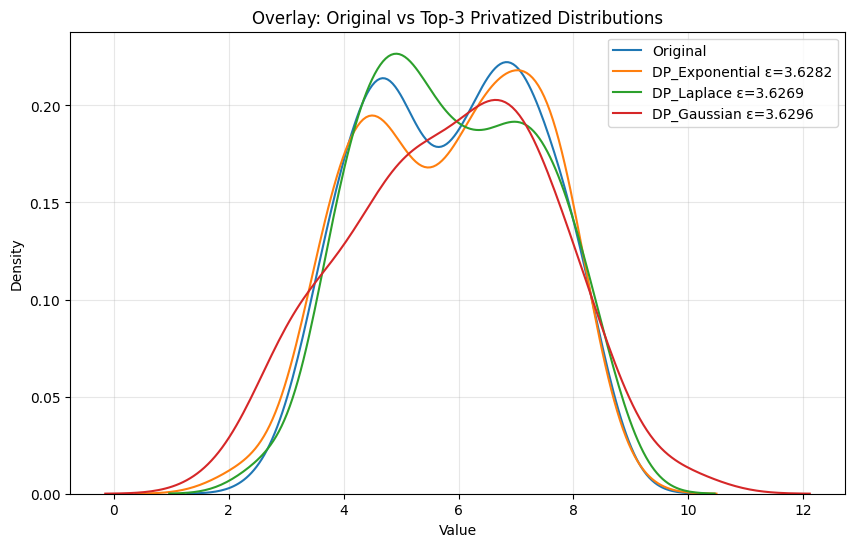


=== Dataset: Finance (Log-Normal) ===
Top-3 Recommendations:
  DP_Laplace: ε=3.7590, mean_rmse=0.3756, ci_width=0.0051, reliability=522.04
  DP_Exponential: ε=3.6296, mean_rmse=0.3891, ci_width=0.0047, reliability=546.82
  DP_Gaussian: ε=3.6315, mean_rmse=0.9421, ci_width=0.0118, reliability=89.95

Similarity Metrics for Top-3:


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


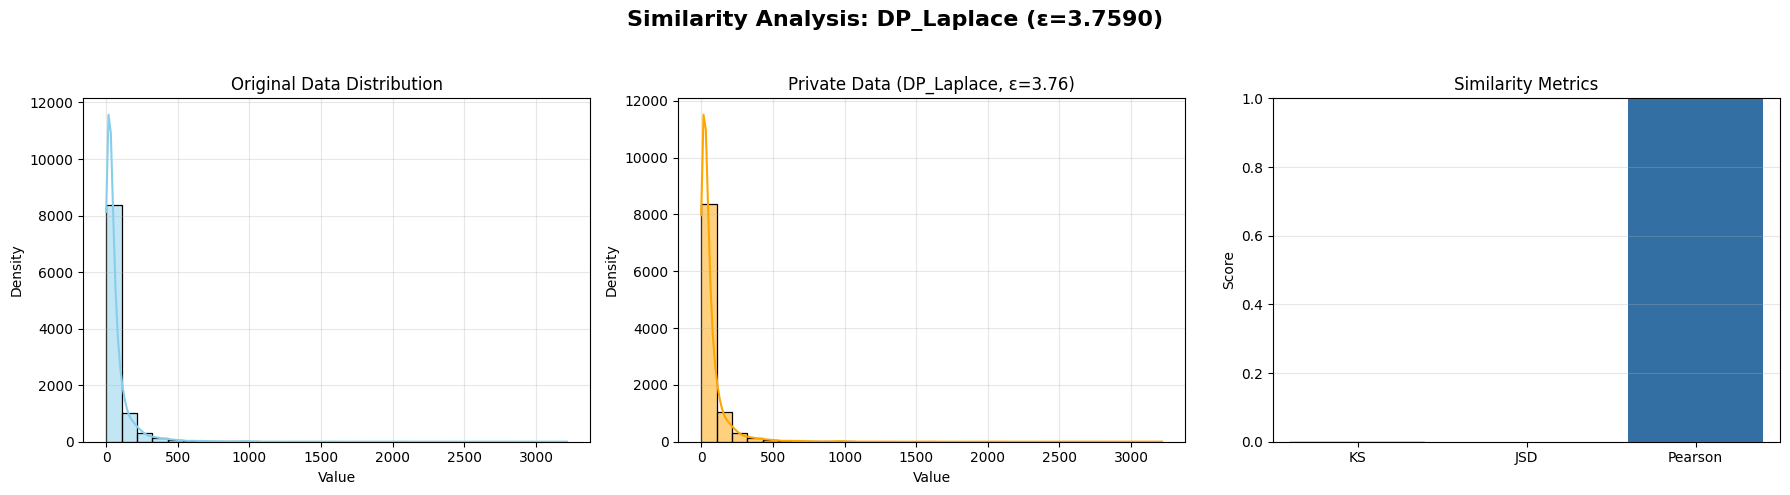

  DP_Laplace: KS=0.0022, JSD=0.0000, Pearson=1.0000


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


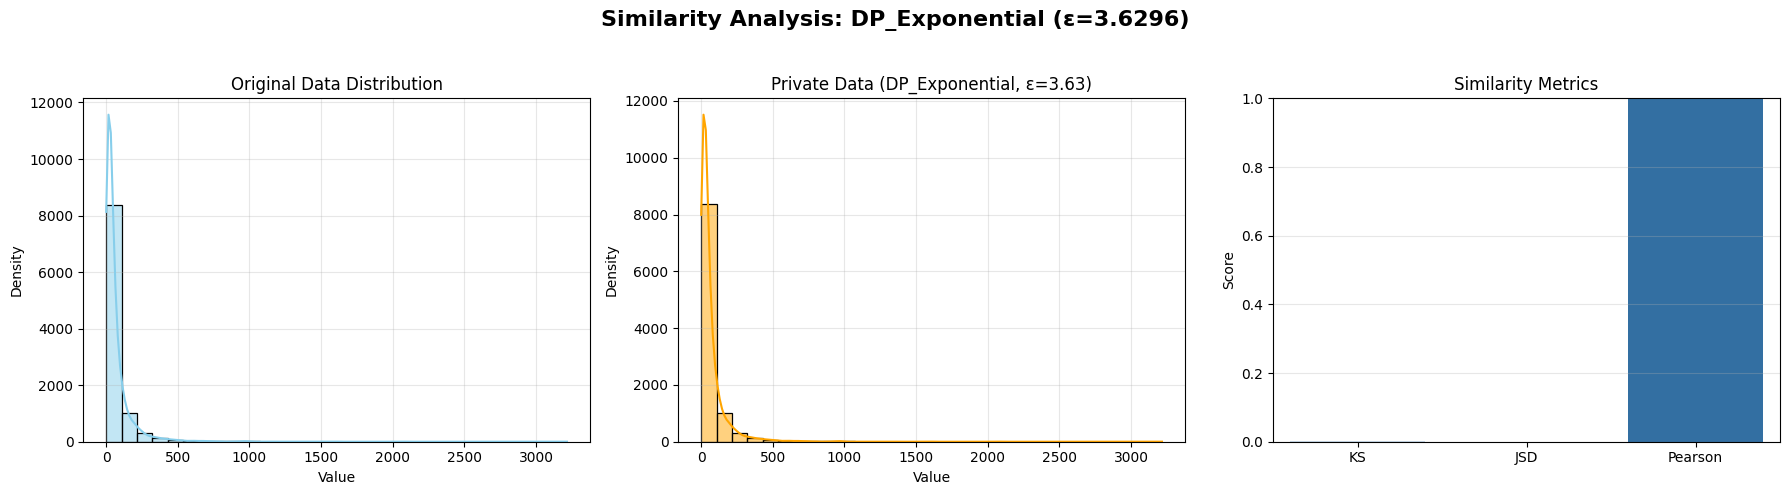

  DP_Exponential: KS=0.0032, JSD=0.0001, Pearson=1.0000


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


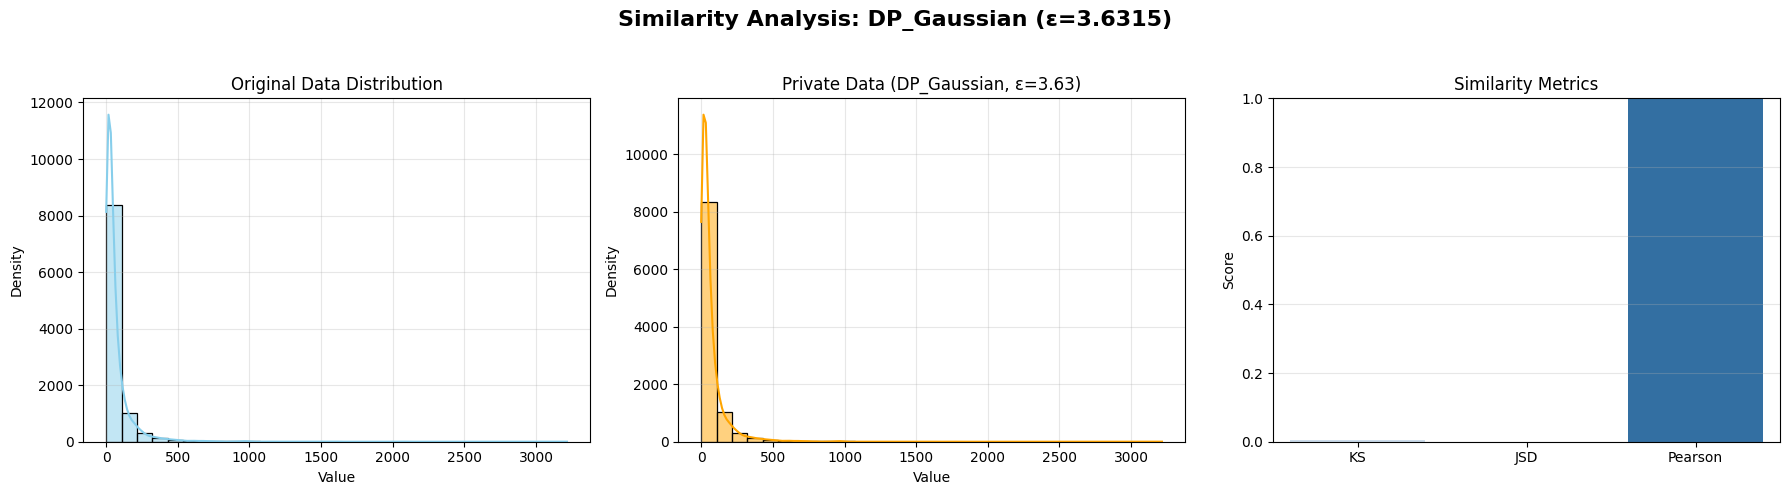

  DP_Gaussian: KS=0.0036, JSD=0.0001, Pearson=1.0000

Confidence Metrics for Top-3:
  DP_Laplace: mean_rmse=0.3747, ci_width=0.0048, reliability=556.00
  DP_Exponential: mean_rmse=0.3921, ci_width=0.0085, reliability=300.04
  DP_Gaussian: mean_rmse=0.9462, ci_width=0.0061, reliability=173.26


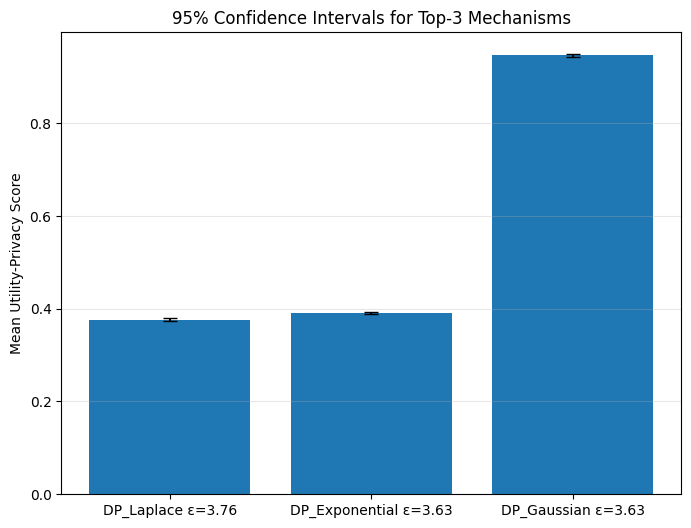

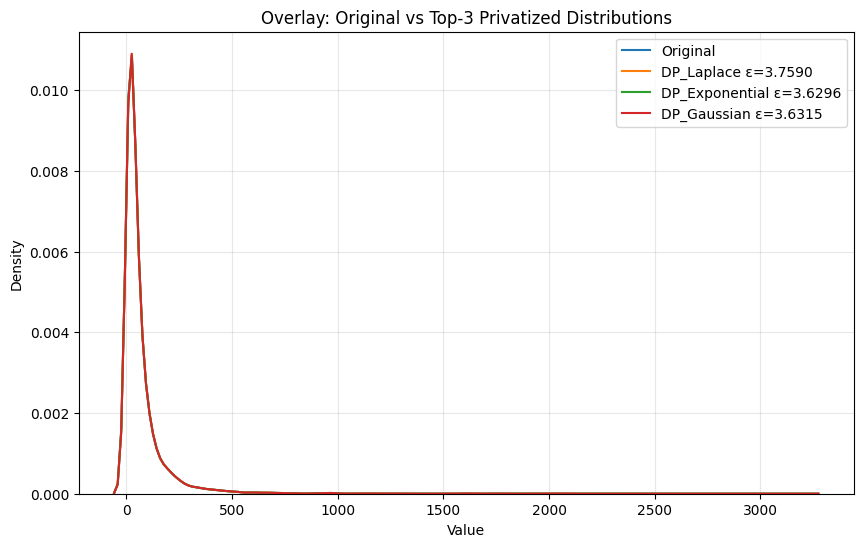


=== Dataset: Sensor Temp (Hourly) ===
Top-3 Recommendations:
  DP_Laplace: ε=3.6300, mean_rmse=0.3755, ci_width=0.0463, reliability=57.52
  DP_Exponential: ε=3.6298, mean_rmse=0.3987, ci_width=0.0437, reliability=57.39
  DP_Gaussian: ε=3.6296, mean_rmse=0.9374, ci_width=0.0617, reliability=17.29

Similarity Metrics for Top-3:


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


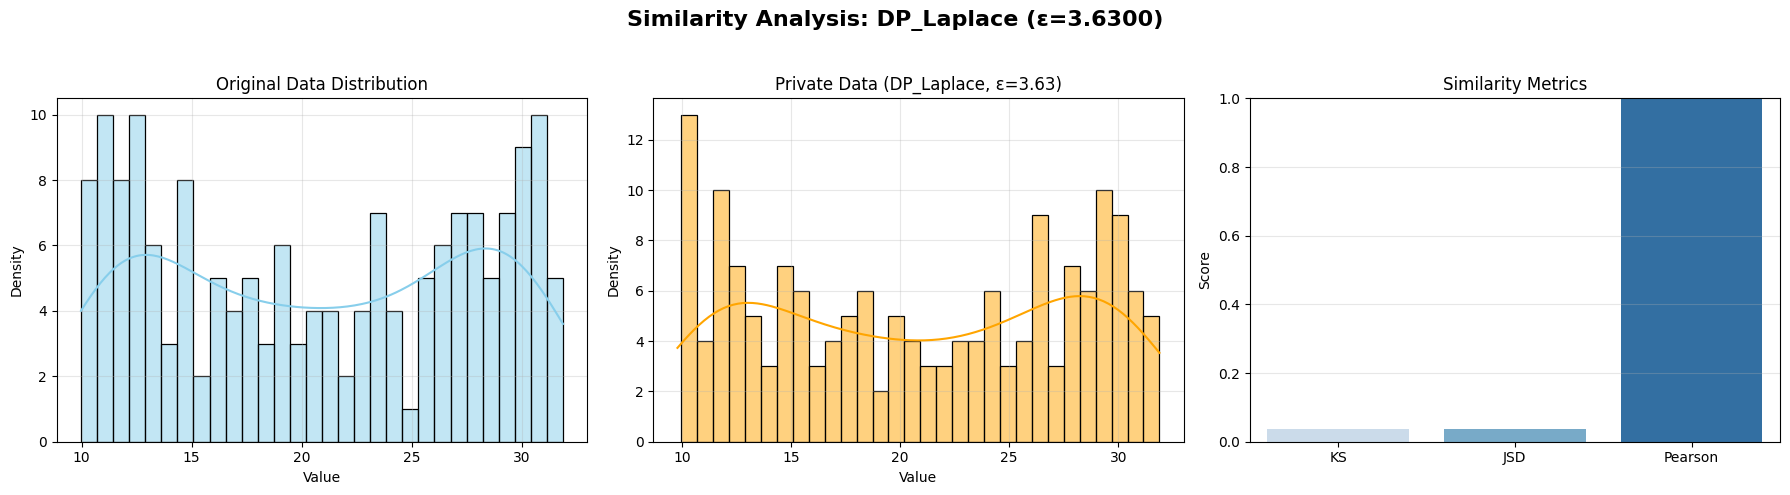

  DP_Laplace: KS=0.0357, JSD=0.0380, Pearson=0.9980


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


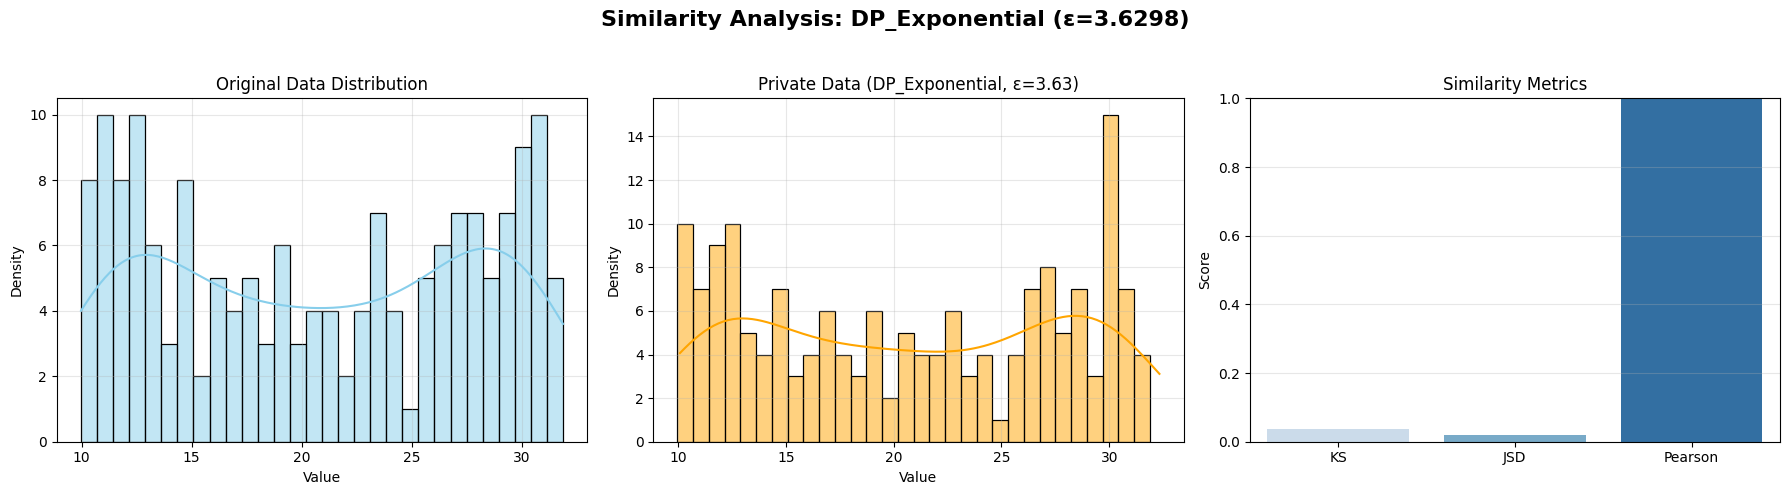

  DP_Exponential: KS=0.0357, JSD=0.0209, Pearson=0.9988


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


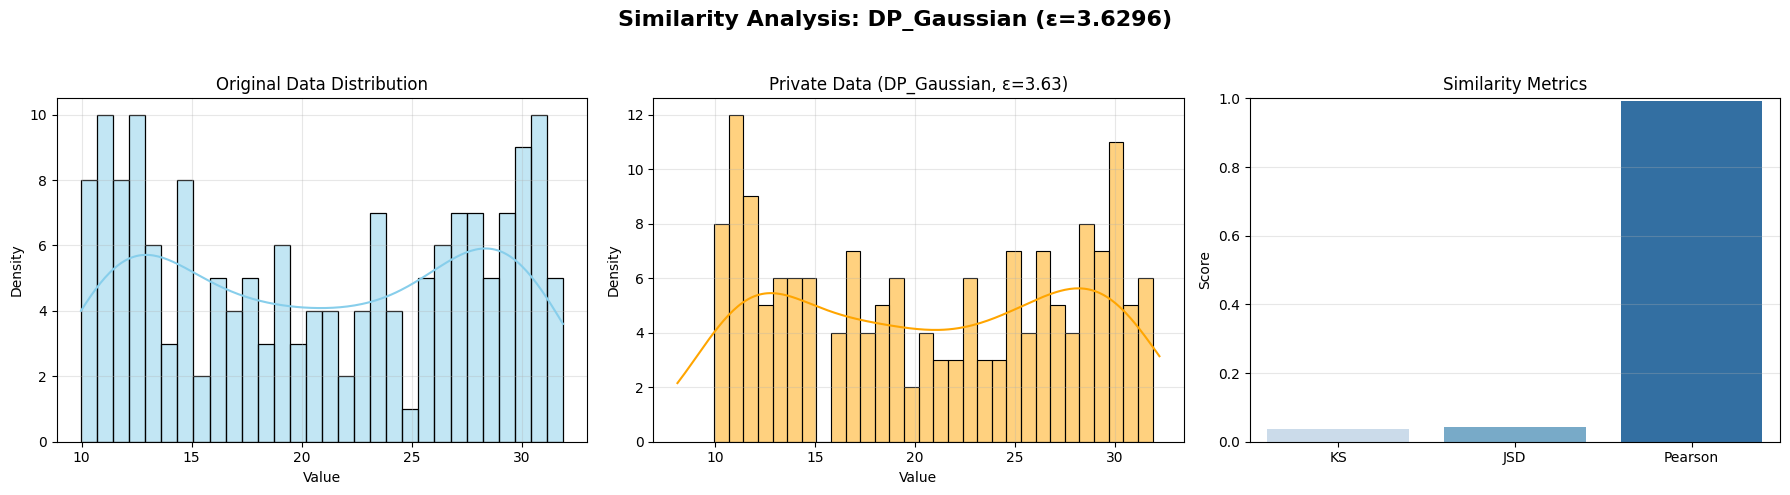

  DP_Gaussian: KS=0.0357, JSD=0.0419, Pearson=0.9908

Confidence Metrics for Top-3:
  DP_Laplace: mean_rmse=0.3967, ci_width=0.0403, reliability=62.55
  DP_Exponential: mean_rmse=0.3902, ci_width=0.0379, reliability=67.62
  DP_Gaussian: mean_rmse=0.9389, ci_width=0.0650, reliability=16.39


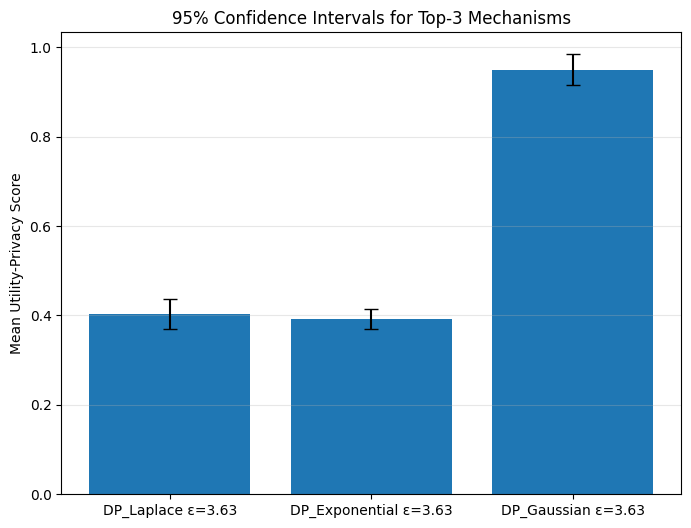

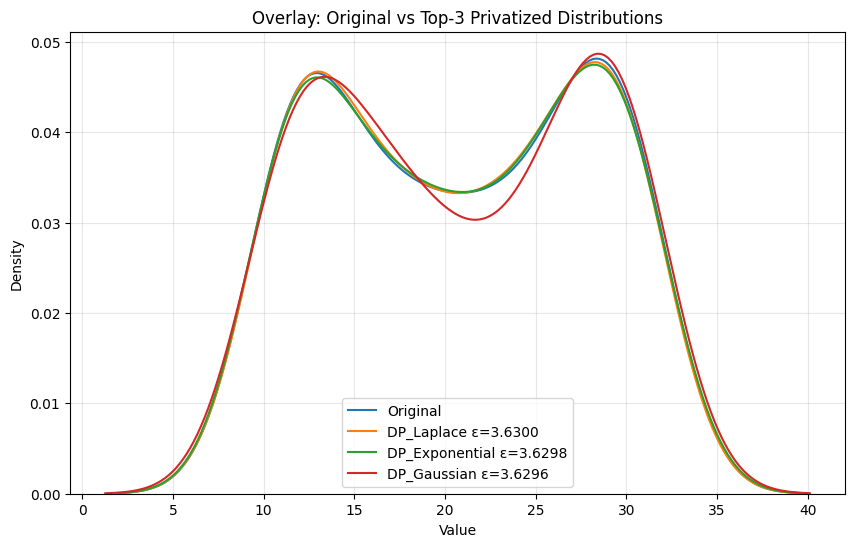


=== Dataset: Heart Rate (Min) ===
Top-3 Recommendations:
  DP_Exponential: ε=3.6296, mean_rmse=0.3839, ci_width=0.0105, reliability=248.08
  DP_Laplace: ε=3.6296, mean_rmse=0.3843, ci_width=0.0112, reliability=232.33
  DP_Gaussian: ε=4.9919, mean_rmse=0.6862, ci_width=0.0145, reliability=100.50

Similarity Metrics for Top-3:


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


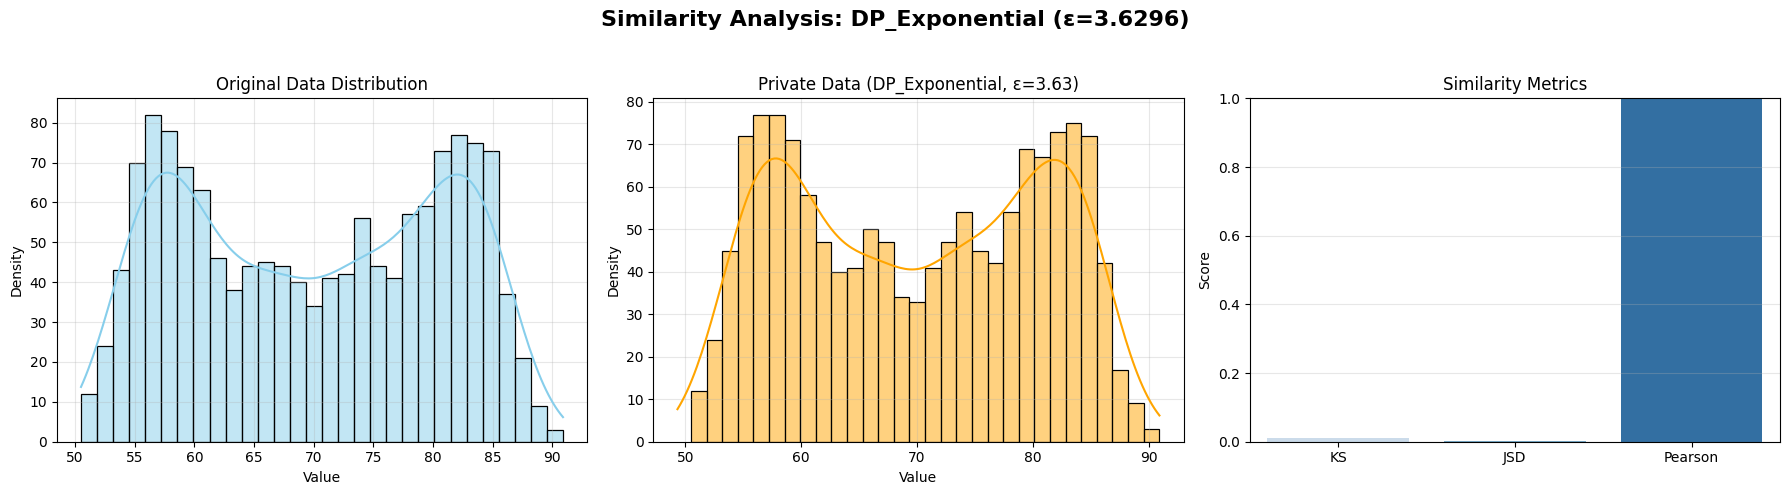

  DP_Exponential: KS=0.0097, JSD=0.0010, Pearson=0.9993


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


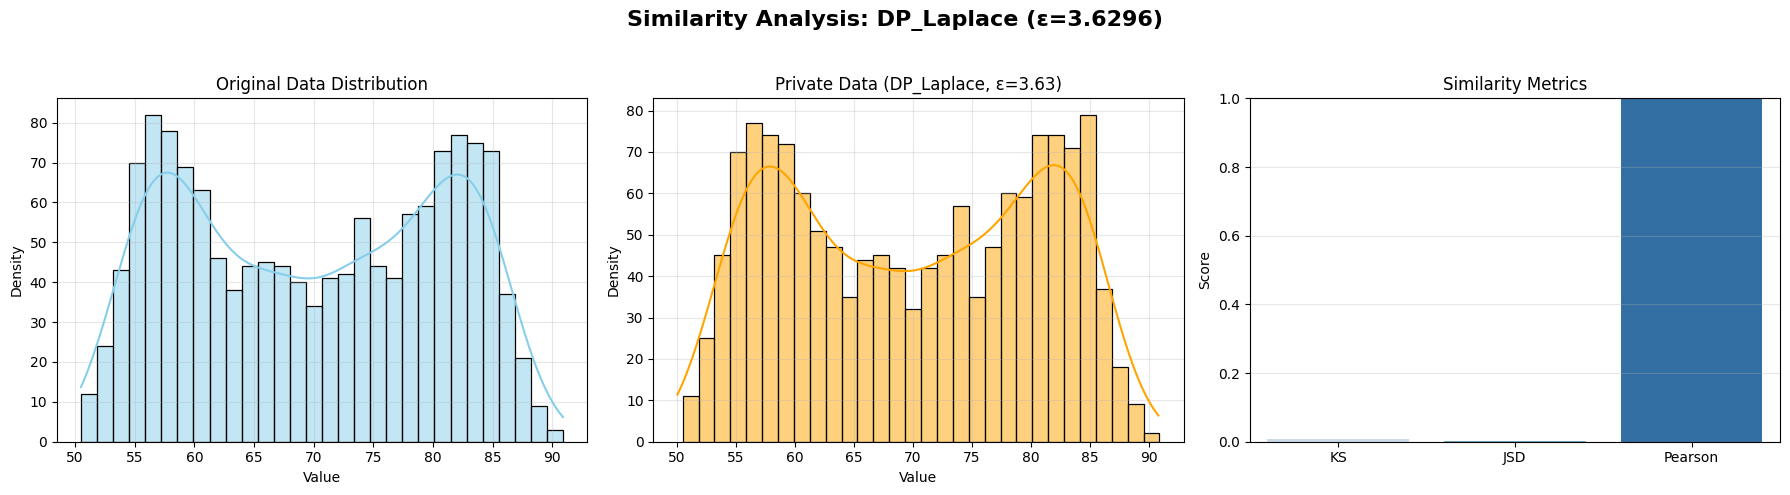

  DP_Laplace: KS=0.0090, JSD=0.0013, Pearson=0.9993


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


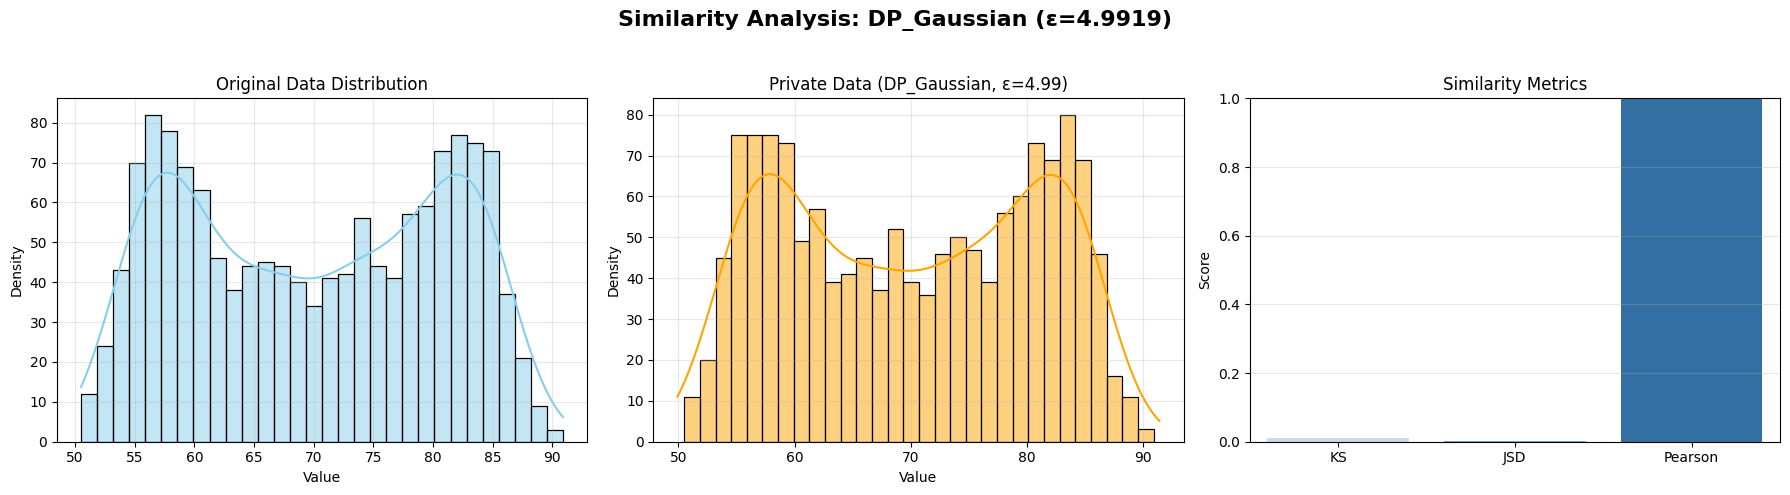

  DP_Gaussian: KS=0.0118, JSD=0.0026, Pearson=0.9979

Confidence Metrics for Top-3:
  DP_Exponential: mean_rmse=0.3942, ci_width=0.0133, reliability=190.74
  DP_Laplace: mean_rmse=0.3865, ci_width=0.0115, reliability=224.98
  DP_Gaussian: mean_rmse=0.6892, ci_width=0.0177, reliability=82.44


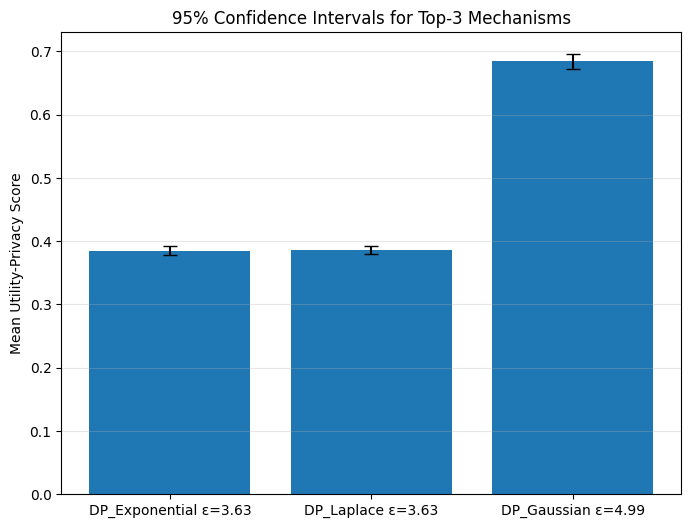

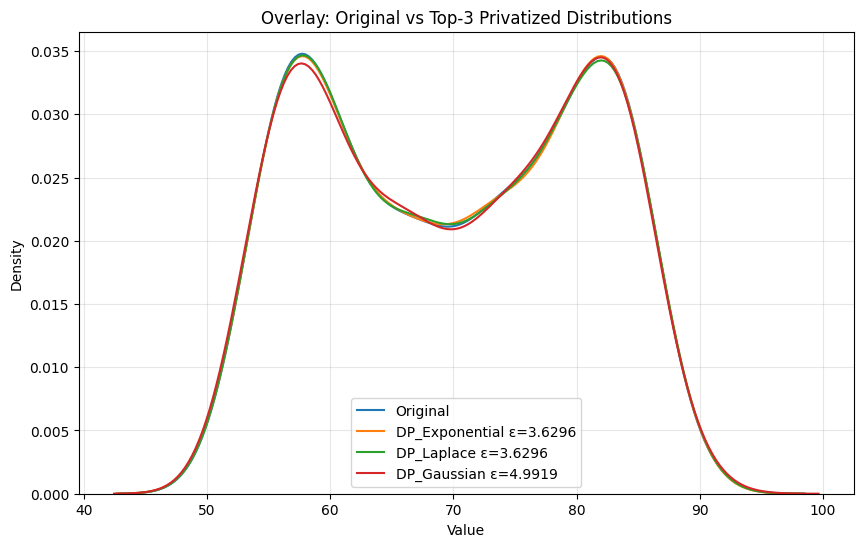


=== Dataset: Web Hits (5k) ===
Top-3 Recommendations:
  DP_Exponential: ε=3.6302, mean_rmse=0.3869, ci_width=0.0069, reliability=374.59
  DP_Laplace: ε=3.6296, mean_rmse=0.3892, ci_width=0.0069, reliability=372.37
  DP_Gaussian: ε=3.6343, mean_rmse=0.9434, ci_width=0.0138, reliability=76.81

Similarity Metrics for Top-3:


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


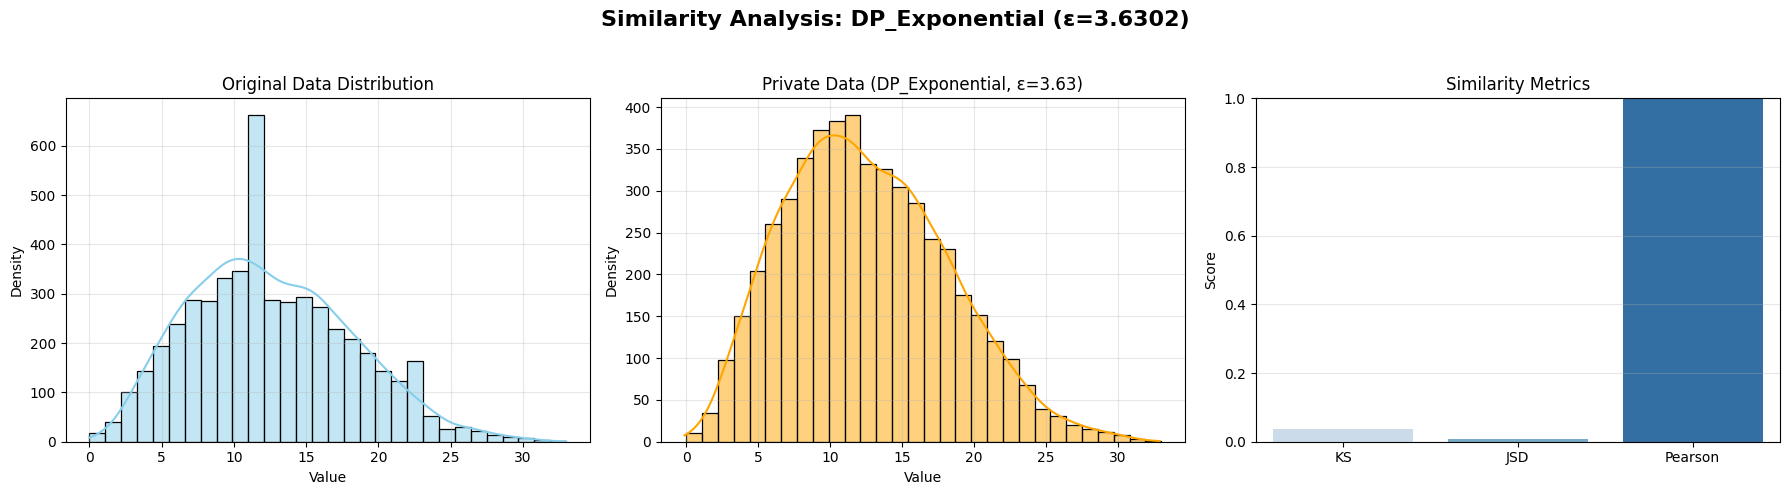

  DP_Exponential: KS=0.0360, JSD=0.0082, Pearson=0.9976


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


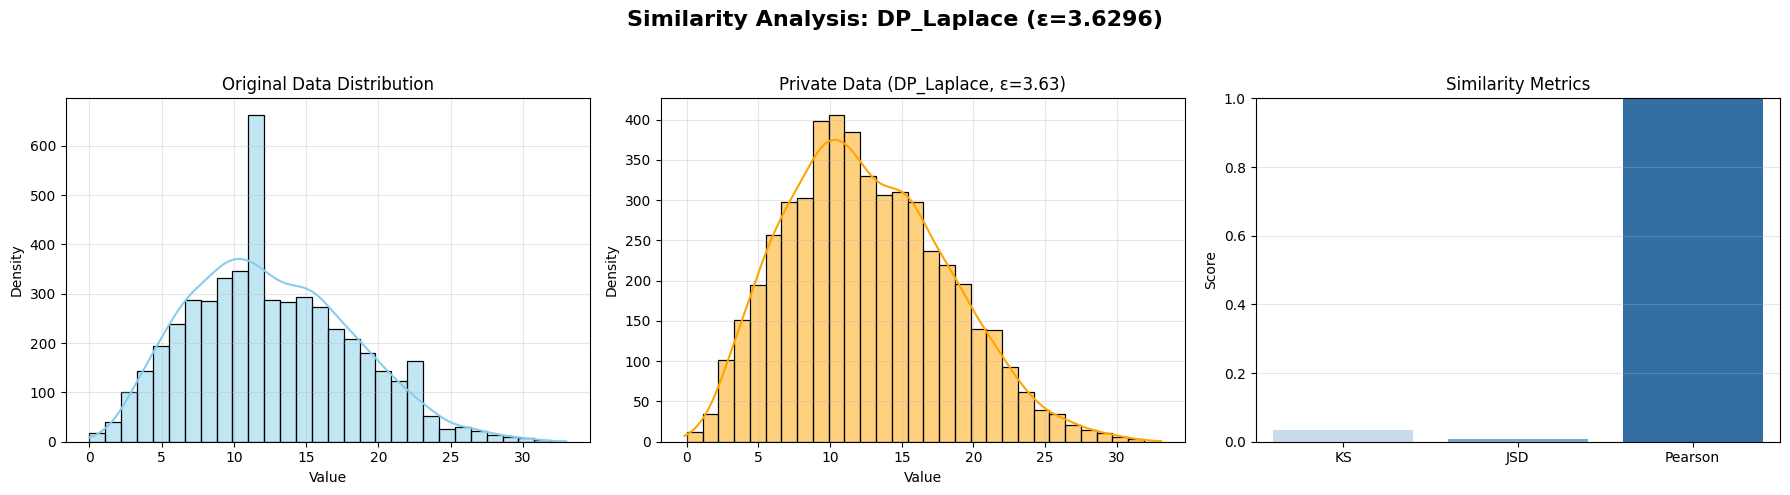

  DP_Laplace: KS=0.0354, JSD=0.0088, Pearson=0.9976


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


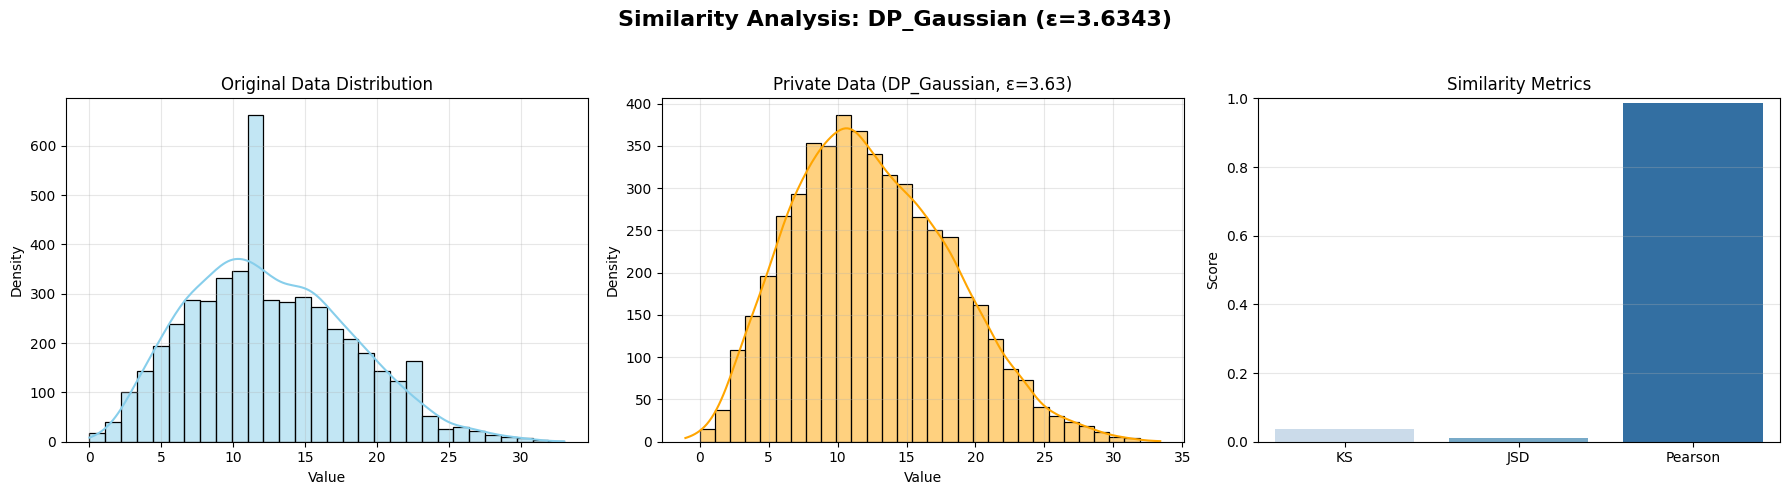

  DP_Gaussian: KS=0.0378, JSD=0.0104, Pearson=0.9863

Confidence Metrics for Top-3:
  DP_Exponential: mean_rmse=0.3908, ci_width=0.0062, reliability=406.17
  DP_Laplace: mean_rmse=0.3910, ci_width=0.0125, reliability=204.60
  DP_Gaussian: mean_rmse=0.9394, ci_width=0.0103, reliability=104.36


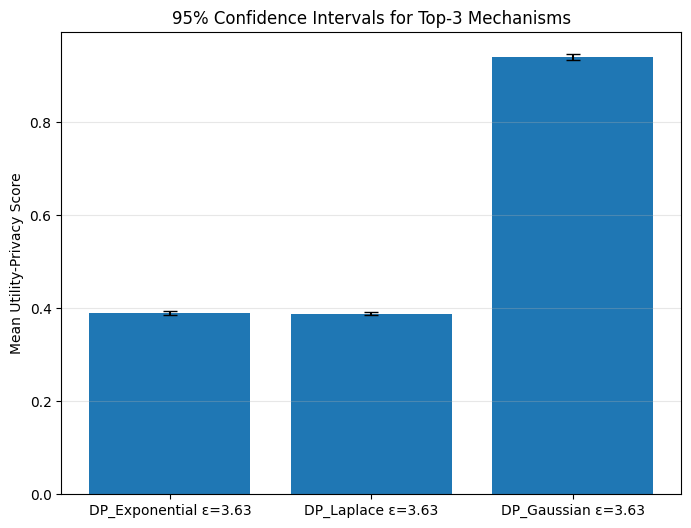

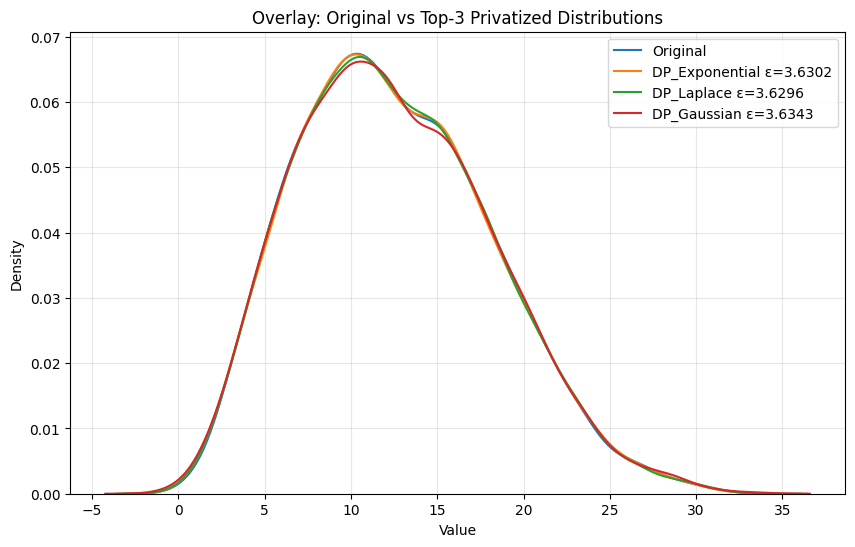


=== Dataset: Cat+Num ===
Top-3 Recommendations:
  DP_Exponential: ε=3.6296, mean_rmse=0.3889, ci_width=0.0099, reliability=259.73
  DP_Laplace: ε=3.6320, mean_rmse=0.3901, ci_width=0.0090, reliability=284.83
  DP_Gaussian: ε=3.6337, mean_rmse=0.9481, ci_width=0.0121, reliability=87.17

Similarity Metrics for Top-3:


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


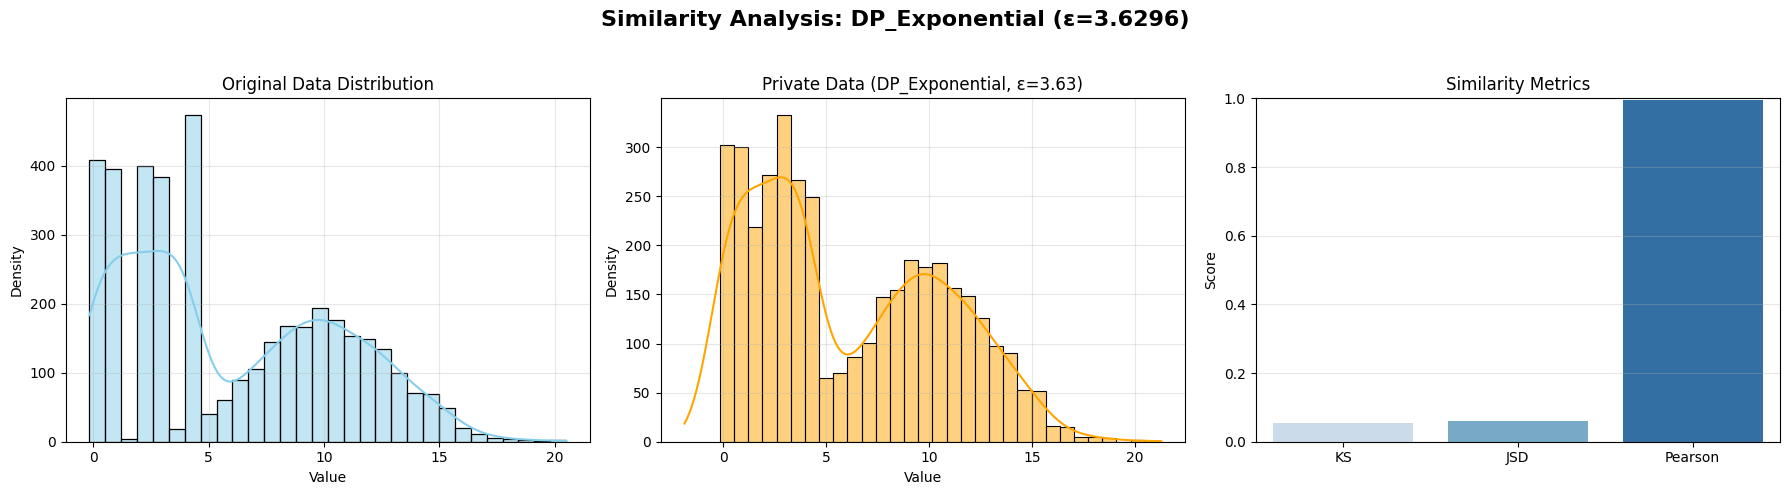

  DP_Exponential: KS=0.0548, JSD=0.0609, Pearson=0.9963


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


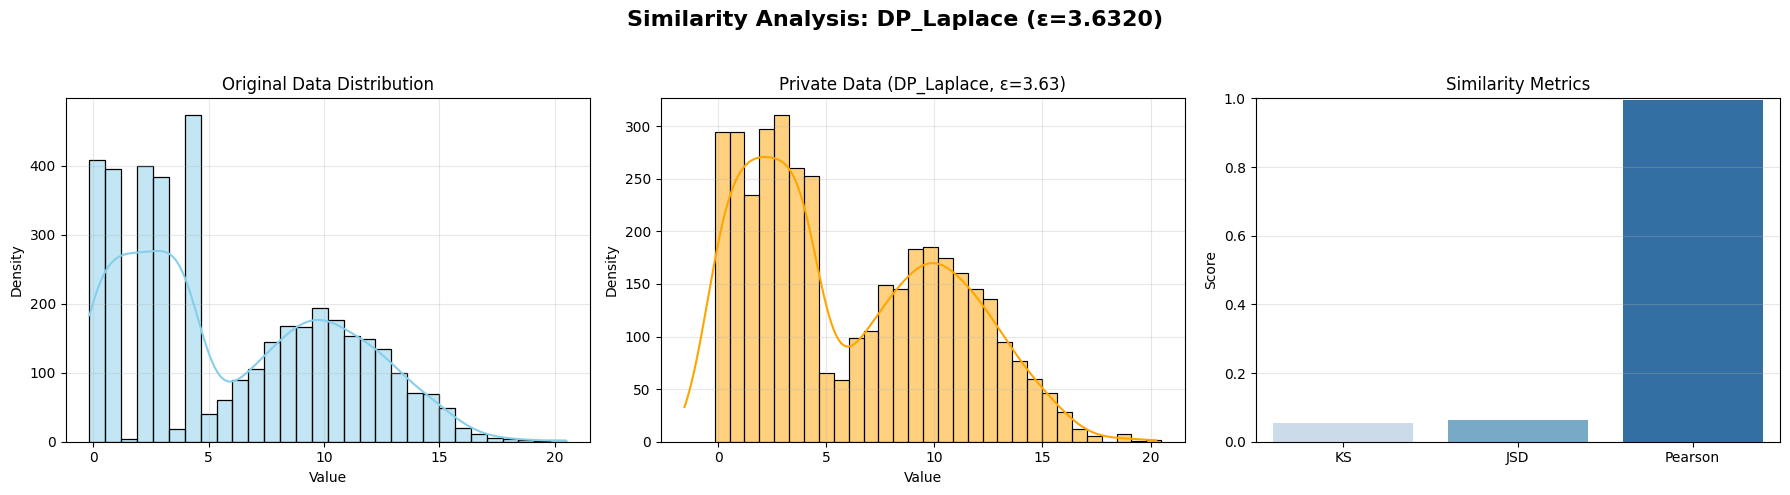

  DP_Laplace: KS=0.0545, JSD=0.0620, Pearson=0.9964


<ipython-input-33-f16b530644c8>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


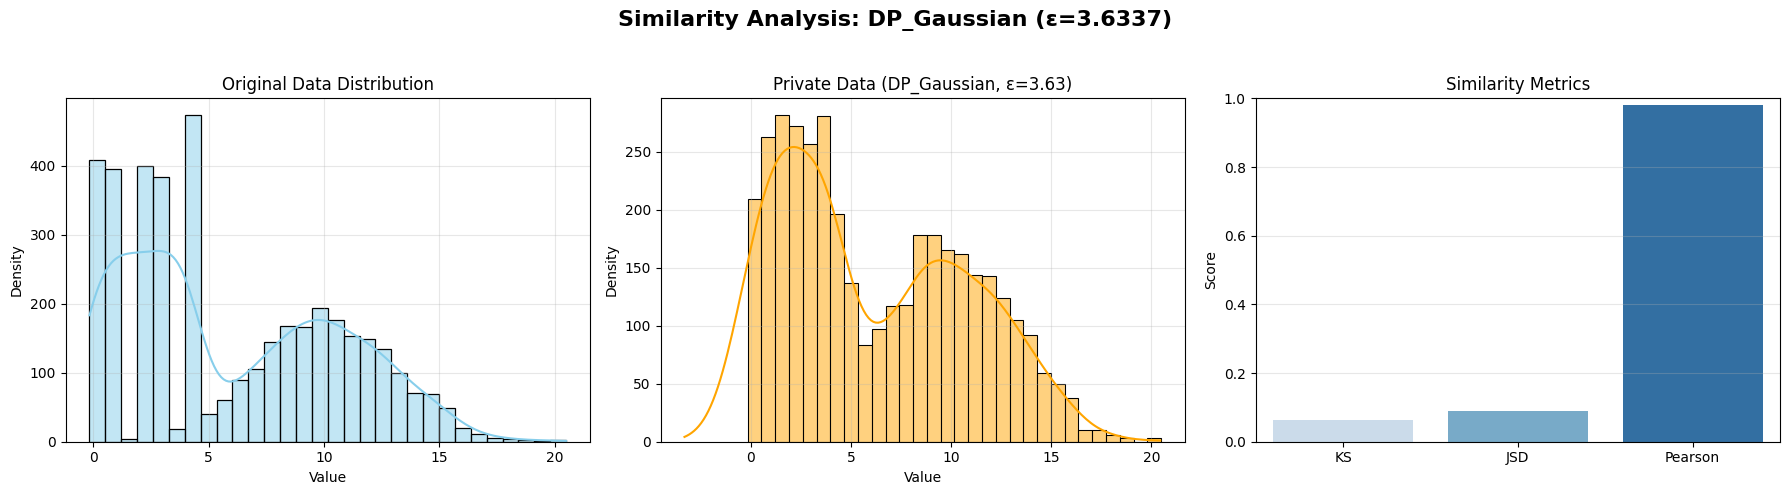

  DP_Gaussian: KS=0.0642, JSD=0.0889, Pearson=0.9805

Confidence Metrics for Top-3:
  DP_Exponential: mean_rmse=0.3900, ci_width=0.0048, reliability=545.55
  DP_Laplace: mean_rmse=0.3898, ci_width=0.0107, reliability=239.76
  DP_Gaussian: mean_rmse=0.9443, ci_width=0.0081, reliability=129.14


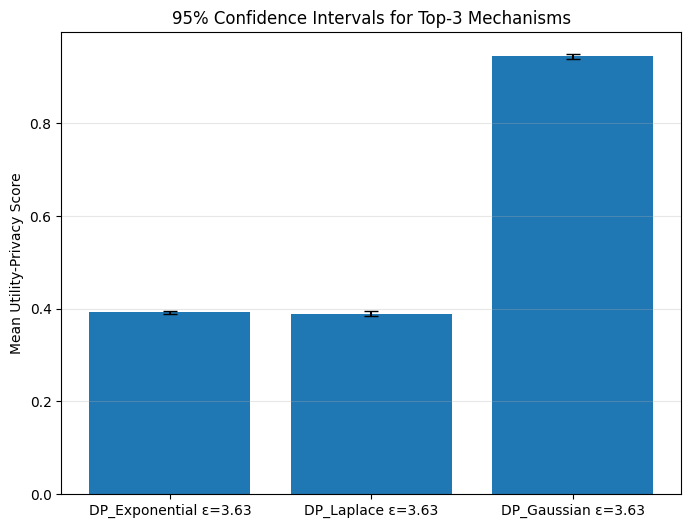

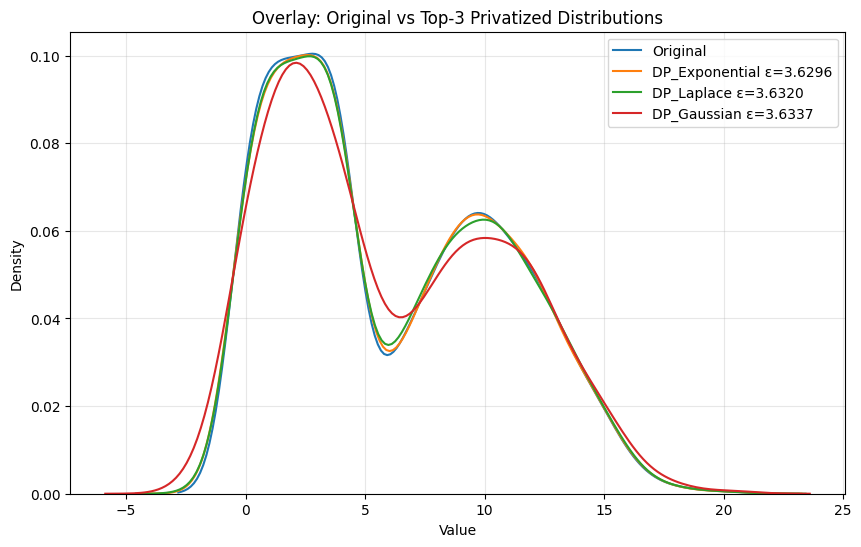

In [34]:
if __name__ == "__main__":
    # 1) Generate all datasets
    all_data = generate_dataset()

    for name, tensor in all_data.items():
        print(f"\n=== Dataset: {name} ===")

        # For list-based APIs convert to Python list if needed
        domain = tensor.tolist()

        # 2) Top-3 Recommendations
        top3 = recommend_top3(domain)
        print("Top-3 Recommendations:")
        for rec in top3:
            print(
                f"  {rec['algorithm']}: ε={rec['epsilon']:.4f}, "
                f"mean_rmse={rec['mean_rmse']:.4f}, ci_width={rec['ci_width']:.4f}, "
                f"reliability={rec['reliability']:.2f}"
            )

        # 3) Similarity Metrics
        print("\nSimilarity Metrics for Top-3:")
        for rec in top3:
            sim = visualize_similarity(domain, rec['algorithm'], rec['epsilon'])
            print(
                f"  {rec['algorithm']}: KS={sim['KS']:.4f}, "
                f"JSD={sim['JSD']:.4f}, Pearson={sim['Pearson']:.4f}"
            )

        # 4) Confidence Metrics
        print("\nConfidence Metrics for Top-3:")
        for rec in top3:
            conf = evaluate_algorithm_confidence(domain, rec['algorithm'], rec['epsilon'])
            rel = performance_explanation_metrics(conf)['reliability']
            print(
                f"  {rec['algorithm']}: mean_rmse={conf['mean']:.4f}, "
                f"ci_width={conf['ci_width']:.4f}, reliability={rel:.2f}"
            )
        visualize_confidence_top3(domain, top3)

        # 5) Overlay Original vs. Privatized
        visualize_overlay_original_and_private(domain, top3)

<ipython-input-35-01e5a1fec5b5>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim, _ = pearsonr(orig_np, priv_np)


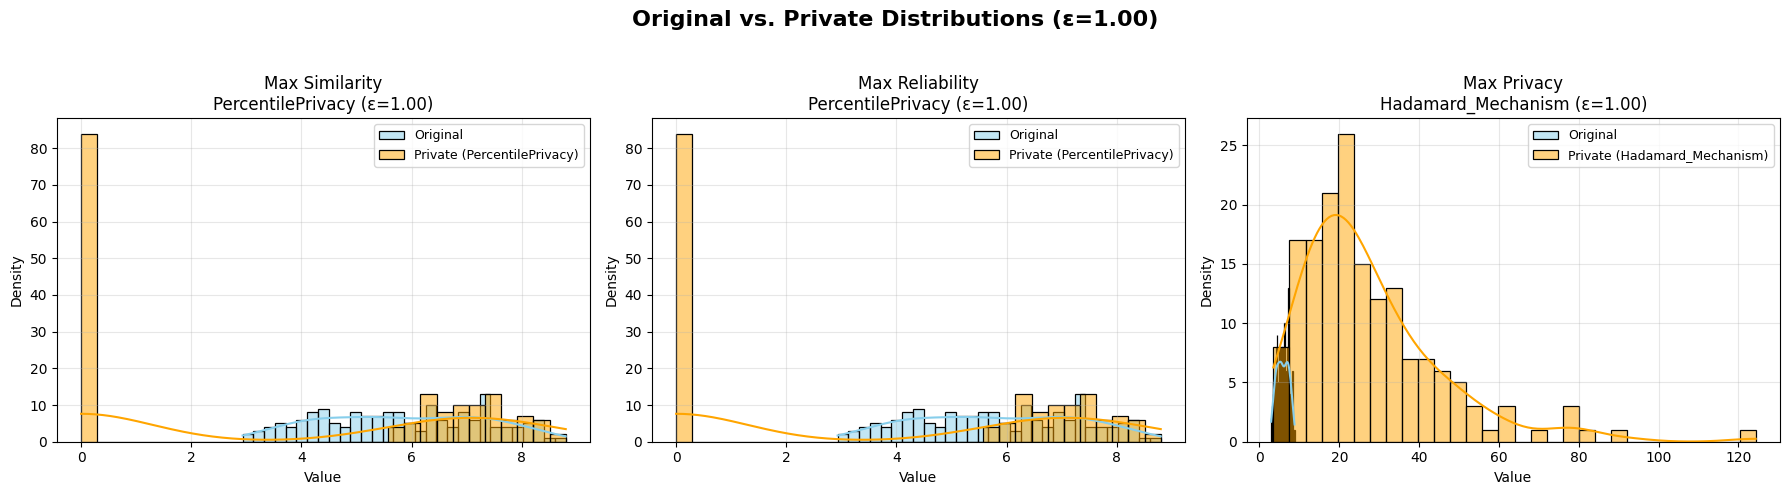

Best by Similarity:  {'algorithm': 'PercentilePrivacy', 'score': np.float32(0.9049)}
Best by Reliability: {'algorithm': 'PercentilePrivacy', 'score': inf}
Best by Privacy:     {'algorithm': 'Hadamard_Mechanism', 'score': 32.9013}


In [37]:
# Energy Consumption with Fixed ε
epsilon = 1
dataset = generate_dataset()
name, tensor = next(iter(dataset.items()))

results = recommend_best_algorithms(
    data                             = tensor,
    epsilon                          = epsilon,
    get_noise_generators             = get_noise_generators,
    calculate_utility_privacy_score  = calculate_utility_privacy_score,
    evaluate_algorithm_confidence    = evaluate_algorithm_confidence,
    performance_explanation_metrics  = performance_explanation_metrics
)

print("Best by Similarity: ",  results["max_similarity"])
print("Best by Reliability:", results["max_reliability"])
print("Best by Privacy:    ", results["max_privacy"])

In [ ]:
# ML Classification with Private Gradients
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
#from presto_privacy_mechanisms import get_noise_generators
#from presto_updated_confidence import evaluate_algorithm_confidence, performance_explanation_metrics
import numpy as np
from scipy.stats import pearsonr

# 1) Generate synthetic classification data
X, y = make_classification(n_samples=2000, n_features=20, n_informative=15,
                           n_redundant=5, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to torch tensors and dataloaders
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
test_ds  = TensorDataset(torch.tensor(X_test,  dtype=torch.float32),
                         torch.tensor(y_test,  dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256)

# 2) Simple MLP model
class MLP(nn.Module):
    def __init__(self, in_features, hidden=50, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# Utility: negative RMSE scorer
def calculate_utility_privacy_score(data, algo, epsilon):
    fn = get_noise_generators()[algo]
    private = fn(data, epsilon)
    if not torch.is_tensor(private):
        private = torch.as_tensor(private, dtype=data.dtype)
    rmse = torch.sqrt(torch.mean((data - private)**2))
    return -rmse.item()

# Recommendation function
def recommend_best_algorithms(data, epsilon):
    noise_gens = get_noise_generators()
    orig_np = data.cpu().numpy()
    best_sim = ("", -1.0)
    best_rel = ("", -1.0)
    algos = list(noise_gens.keys())
    for algo in algos:
        fn = noise_gens[algo]
        private = fn(data, epsilon)
        private = torch.as_tensor(private, dtype=data.dtype) if not torch.is_tensor(private) else private
        priv_np = private.cpu().numpy()
        sim, _ = pearsonr(orig_np, priv_np)
        if sim > best_sim[1]:
            best_sim = (algo, sim)
        # confidence & reliability
        conf = evaluate_algorithm_confidence(data, algo, epsilon)
        perf = performance_explanation_metrics(conf)
        rel = perf['reliability']
        if rel > best_rel[1]:
            best_rel = (algo, rel)
    return best_sim[0], best_rel[0]

# 3) Baseline training (no privacy)
def train_and_evaluate(model):
    opt = optim.SGD(model.parameters(), lr=0.1)
    crit = nn.CrossEntropyLoss()
    # train
    model.train()
    for epoch in range(5):
        for xb, yb in train_loader:
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
    # evaluate
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb).argmax(dim=1)
            correct += (preds==yb).sum().item()
            total   += yb.size(0)
    return correct/total

# Data for recommendation: flatten all train inputs
flat_data = torch.tensor(X_train.flatten(), dtype=torch.float32)

epsilon = 1.0
best_sim_algo, best_rel_algo = recommend_best_algorithms(flat_data, epsilon)

# Baseline accuracy
base_model = MLP(20).to('cpu')
acc_base = train_and_evaluate(base_model)

# 4) DP training: apply best reliability algorithm to gradients
dp_model = MLP(20).to('cpu')
opt = optim.SGD(dp_model.parameters(), lr=0.1)
crit = nn.CrossEntropyLoss()
noise_fn = get_noise_generators()[best_rel_algo]

dp_model.train()
for epoch in range(5):
    for xb, yb in train_loader:
        opt.zero_grad()
        logits = dp_model(xb)
        loss = crit(logits, yb)
        loss.backward()
        # apply privacy mechanism to gradients
        with torch.no_grad():
            for p in dp_model.parameters():
                if p.grad is not None:
                    g = p.grad
                    noised = noise_fn(g, epsilon)
                    p.grad.copy_(torch.as_tensor(noised, dtype=g.dtype))
        opt.step()

# DP evaluation
acc_dp = train_and_evaluate(dp_model)

print(f"Baseline Accuracy (no privacy): {acc_base*100:.2f}%")
print(f"DP Accuracy with '{best_rel_algo}':        {acc_dp*100:.2f}%")


<ipython-input-24-4dc98067b2c6>:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim, _ = pearsonr(orig_np, priv_np)


Baseline Accuracy (no privacy): 93.00%
DP Accuracy with 'PercentilePrivacy':        94.00%


0.8066912667537723


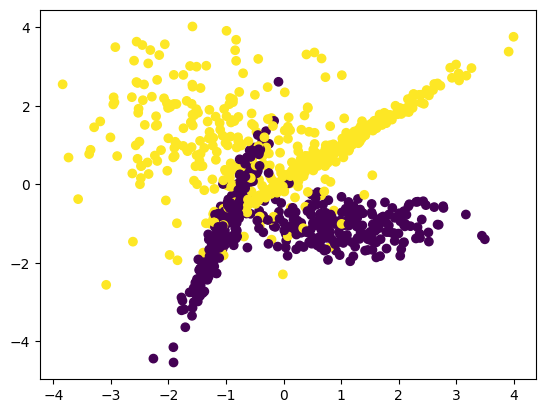

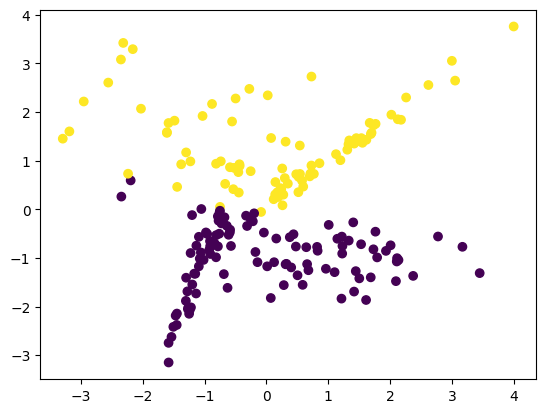

In [29]:

!pip install gpytorch
!pip install opacus
!pip install GPy

import GPy
import gpytorch

import math
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.set_default_dtype(torch.float64)

# import pandas as pd, re
from scipy import stats as st
from scipy.stats import ks_2samp, pearsonr
from scipy.spatial.distance import jensenshannon

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

from opacus.privacy_engine import PrivacyEngine

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure()
plt.scatter(X[:,0], X[:,1],c=y)
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train, y_train)
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# A simple binary classifier model
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

def dp_function(noise_multiplier, max_grad_norm):
    privacy_engine = PrivacyEngine()
    # Instantiate the model, loss function, and optimizer
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    model = BinaryClassifier(input_size=X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # apply the privacy "engine"
    model, optimizer, data_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_dataloader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=max_grad_norm,
    )
    return model, optimizer, criterion, data_loader, privacy_engine

def dp_function_train_and_pred(model, optimizer, criterion, train_dataloader, X_test):
    # This code runs the DP-impacted model to compute the Accuracy

    # Training loop
    epochs = 10
    for epoch in range(epochs):
        for inputs, labels in train_dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.double())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Evaluation
    with torch.no_grad():
        predicted = model(X_test)
        predicted_classes = (predicted > 0.5).float()
        accuracy = (predicted_classes.squeeze() == y_test).sum().item() / y_test.size(0)
        #print(f'Accuracy: {accuracy:.4f}')

    return predicted_classes, accuracy

def dp_target(noise_multiplier, max_grad_norm):
    # apply DP to ML
    model, optimizer, criterion, train_dataloader, privacy_engine = dp_function(noise_multiplier, max_grad_norm)
    # compute accuracy
    predicted_classes, accuracy = dp_function_train_and_pred(model, optimizer, criterion, train_dataloader, X_test)
    return accuracy, privacy_engine, predicted_classes

accuracy, privacy_engine, predicted_classes = dp_target(1.,1.)

plt.figure()
plt.scatter(X_test[:,0],X_test[:,1], c=predicted_classes)
print(privacy_engine.get_epsilon(.1))
# For delta = .1
# params: eps, acc
# (10, 1.): -0.09, .84
# (1.1, 1.): 0.62, .865
# (.1,.1): 650, .885
# (100., 1.): -.01, .51

0.8066912667537723


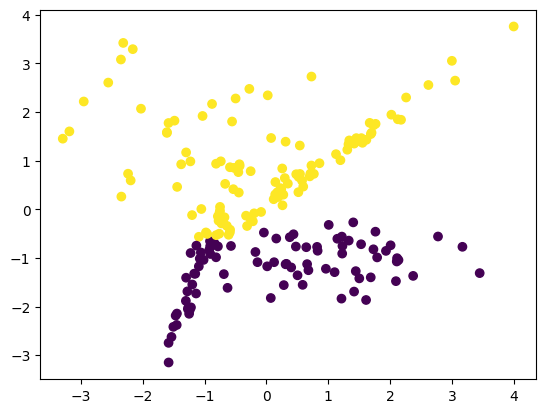

In [30]:
# Testing a simpler classification model

# Simple Logistic regression / classification
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted

def dp_function2(noise_multiplier, max_grad_norm):
    privacy_engine = PrivacyEngine()
    # Instantiate the model, loss function, and optimizer
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    model = LogisticRegression(input_size=X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # apply the privacy "engine"
    model, optimizer, data_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_dataloader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=max_grad_norm,
    )
    return model, optimizer, criterion, data_loader, privacy_engine

def dp_target2(noise_multiplier, max_grad_norm):
    # apply DP to ML
    model, optimizer, criterion, train_dataloader, privacy_engine = dp_function2(noise_multiplier, max_grad_norm)
    # compute accuracy
    predicted_classes, accuracy = dp_function_train_and_pred(model, optimizer, criterion, train_dataloader, X_test)
    return accuracy, privacy_engine, predicted_classes

accuracy, privacy_engine, predicted_classes = dp_target2(1.,1.)

plt.figure()
plt.scatter(X_test[:,0],X_test[:,1], c=predicted_classes)
print(privacy_engine.get_epsilon(.1))

In [31]:
# This function uses Bayesian optimization to identify the pareto front for minimal epsilon and maximum accuracy by exploring
# the Opacus values of noise multiplier and max grad norm.
# The Bayesian Optimization algorithm used is random scalarization: https://arxiv.org/pdf/1805.12168.pdf
# The user provides their desired delta, which is used to compute epsilon.
# The user can then select their desired accuracy and epsilon from the pareto front and we can provide the optimal
# values of noise multiplier and max grad norm to achieve that accuracy and epsilon.

# Some data I computed by choosing the parameters myself.
# (noise multiplier, max grad norm): epsilon, accuracy
# (10, 1.): -0.09, .84
# (1.1, 1.): 0.62, .865
# (.1,.1): 650, .885
# (100., 1.): -.01, .51
def dp_pareto_front():
    # delta is .1 below.
    delta = .1
    accuracy_ = []
    epsilon_ = []
    x1 = np.logspace(np.log10(.1), np.log10(100), 20)
    x2 = np.logspace(np.log10(.1), np.log10(10), 20)
    xg1, xg2 = np.meshgrid(x1, x2)
    Xg = np.hstack((xg1.flatten()[:,None], xg2.flatten()[:,None]))
    measured_points = []

    X_params = np.asarray([[100., 1.],[10,1.],[1.1, 1.],[.1, .1]])
    Y_params = np.asarray([[-.01, .51],[-.09, .84],[.62,.865],[650,.885]])

    alphas = np.asarray([1,1])

    for i in range(100):
        #print('run',i)
        # train our GPs using all our prior data.
        m1 = GPy.models.SparseGPRegression(X_params, Y_params[:,0][:,None], GPy.kern.RBF(2))
        m2 = GPy.models.SparseGPRegression(X_params, Y_params[:,1][:,None], GPy.kern.RBF(2))
        m1.optimize('bfgs', max_iters=100)
        m2.optimize('bfgs', max_iters=100)

        # which data points are unmeasured?
        unmeasured_points = np.setdiff1d(np.arange(0,Xg.shape[0]),measured_points)

        # Get the mean and covariance of the two GPs for the unmeasured (x,y) values.
        mean1, Cov1 = m1.predict_noiseless(Xg[unmeasured_points,:], full_cov=True)
        mean2, Cov2 = m2.predict_noiseless(Xg[unmeasured_points,:], full_cov=True)

        # Sample the GPs using Thompson sampling, with 1 sample for each property we want to maximize.
        Z1  = np.random.multivariate_normal(mean1.flatten(), Cov1, 1).T
        Z2  = np.random.multivariate_normal(mean2.flatten(), Cov2, 1).T

        # Find the full pareto front.
        lam = np.random.dirichlet(alphas,1)

        # solve for the point that maximizes our objective function
        # !!! Want min epsilon, so negative for Z1
        pt = np.argmax(-lam[0,0]*Z1 + lam[0,1]*Z2)
        pt = unmeasured_points[pt]
        measured_points = np.append(measured_points, pt)

        accuracy, privacy_engine, predicted_classes = dp_target(Xg[pt,0], Xg[pt,1])
        epsilon = privacy_engine.get_epsilon(delta)
        epsilon_.append(epsilon)
        accuracy_.append(accuracy)
        X_params = np.vstack((X_params, np.asarray([Xg[pt,0], Xg[pt,1]])[None,:]))
        Y_params = np.vstack((Y_params, np.asarray([epsilon,accuracy])))
        #print('epsilon', epsilon)
    return measured_points, epsilon_, accuracy_

measured_points, epsilon_, accuracy_ = dp_pareto_front()

import pickle
from google.colab import drive
drive.mount('/content/drive')
m = []
with open('/content/drive/MyDrive/my_variables.pkl', 'wb') as f:
    pickle.dump((measured_points, epsilon_, accuracy_), f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[1.00000000e-01 1.43844989e-01 2.06913808e-01 2.97635144e-01
 4.28133240e-01 6.15848211e-01 8.85866790e-01 1.27427499e+00
 1.83298071e+00 2.63665090e+00 3.79269019e+00 5.45559478e+00
 7.84759970e+00 1.12883789e+01 1.62377674e+01 2.33572147e+01
 3.35981829e+01 4.83293024e+01 6.95192796e+01 1.00000000e+02]


Text(0, 0.5, 'accuracy')

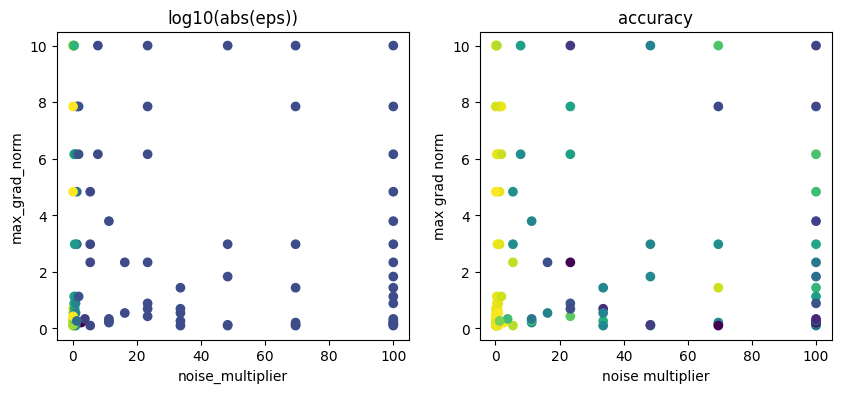

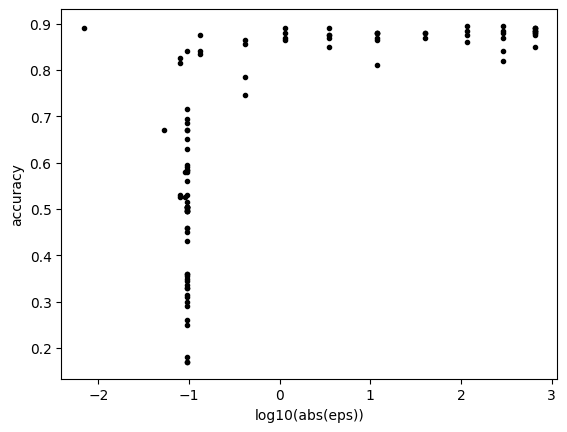

In [32]:
x1 = np.logspace(np.log10(.1), np.log10(100), 20)
x2 = np.logspace(np.log10(.1), np.log10(10), 20)
print(x1)
xg1, xg2 = np.meshgrid(x1, x2)
Xg = np.hstack((xg1.flatten()[:,None], xg2.flatten()[:,None]))

measured_points = measured_points.astype(int)
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.scatter(Xg[measured_points,0], Xg[measured_points,1], c=np.log10(np.abs(np.asarray(epsilon_))))
plt.xlabel('noise_multiplier')
plt.ylabel('max_grad_norm')
plt.title('log10(abs(eps))')
plt.subplot(1,2,2)
plt.scatter(Xg[measured_points,0], Xg[measured_points,1], c=np.asarray(accuracy_))
plt.xlabel('noise multiplier')
plt.ylabel('max grad norm')
plt.title('accuracy')
plt.figure()
plt.plot(np.log10(np.asarray(np.abs(epsilon_))), np.asarray(accuracy_), 'k.')
plt.xlabel('log10(abs(eps))')
plt.ylabel('accuracy')

In [33]:
X_params = np.asarray([[100., 1.],[10,1.],[1.1, 1.],[.1, .1]])
Y_params = np.asarray([[-.01, .51],[-.09, .84],[.62,.865],[650,.885]])
x1 = np.logspace(.1, 100, 20)
x2 = np.logspace(.1, 10, 20)
xg1, xg2 = np.meshgrid(x1, x2)
Xg = np.hstack((xg1.flatten()[:,None], xg2.flatten()[:,None]))
print(Xg.shape)

pt = 3
temp = np.asarray([Xg[pt,0], Xg[pt,1]])[None,:]
X_params = np.vstack((X_params, temp))

print(temp.shape)
print(X_params.shape)

(400, 2)
(1, 2)
(5, 2)


In [34]:
# This function uses Bayesian optimization to identify the pareto front for minimal epsilon and maximum accuracy by exploring
# the Opacus values of noise multiplier and max grad norm.
# The Bayesian Optimization algorithm used is random scalarization: https://arxiv.org/pdf/1805.12168.pdf
# The user provides their desired delta, which is used to compute epsilon.
# The user can then select their desired accuracy and epsilon from the pareto front and we can provide the optimal
# values of noise multiplier and max grad norm to achieve that accuracy and epsilon.

# Some data I computed by choosing the parameters myself.
# (noise multiplier, max grad norm): epsilon, accuracy
# (10, 1.): -0.09, .84
# (1.1, 1.): 0.62, .865
# (.1,.1): 650, .885
# (100., 1.): -.01, .51
def dp_pareto_front_LR():
    # delta is .1 below.
    delta = .1
    accuracy_ = []
    epsilon_ = []
    x1 = np.logspace(np.log10(.1), np.log10(100), 20)
    x2 = np.logspace(np.log10(.1), np.log10(10), 20)
    xg1, xg2 = np.meshgrid(x1, x2)
    Xg = np.hstack((xg1.flatten()[:,None], xg2.flatten()[:,None]))
    measured_points = []

    X_params = np.asarray([[100., 1.],[10,1.],[1.1, 1.],[.1, .1]])
    Y_params = np.asarray([[-.01, .51],[-.09, .84],[.62,.865],[650,.885]])

    alphas = np.asarray([1,1])

    for i in range(100):
        #print('run',i)
        # train our GPs using all our prior data.
        m1 = GPy.models.SparseGPRegression(X_params, Y_params[:,0][:,None], GPy.kern.RBF(2))
        m2 = GPy.models.SparseGPRegression(X_params, Y_params[:,1][:,None], GPy.kern.RBF(2))
        m1.optimize('bfgs', max_iters=100)
        m2.optimize('bfgs', max_iters=100)

        # which data points are unmeasured?
        unmeasured_points = np.setdiff1d(np.arange(0,Xg.shape[0]),measured_points)

        # Get the mean and covariance of the two GPs for the unmeasured (x,y) values.
        mean1, Cov1 = m1.predict_noiseless(Xg[unmeasured_points,:], full_cov=True)
        mean2, Cov2 = m2.predict_noiseless(Xg[unmeasured_points,:], full_cov=True)

        # Sample the GPs using Thompson sampling, with 1 sample for each property we want to maximize.
        Z1  = np.random.multivariate_normal(mean1.flatten(), Cov1, 1).T
        Z2  = np.random.multivariate_normal(mean2.flatten(), Cov2, 1).T

        # Find the full pareto front.
        lam = np.random.dirichlet(alphas,1)

        # solve for the point that maximizes our objective function
        # !!! Want min epsilon, so negative for Z1
        pt = np.argmax(-lam[0,0]*Z1 + lam[0,1]*Z2)
        pt = unmeasured_points[pt]
        measured_points = np.append(measured_points, pt)

        accuracy, privacy_engine, predicted_classes = dp_target2(Xg[pt,0], Xg[pt,1])
        epsilon = privacy_engine.get_epsilon(delta)
        epsilon_.append(epsilon)
        accuracy_.append(accuracy)
        X_params = np.vstack((X_params, np.asarray([Xg[pt,0], Xg[pt,1]])[None,:]))
        Y_params = np.vstack((Y_params, np.asarray([epsilon,accuracy])))
        #print('epsilon', epsilon)
    return measured_points, epsilon_, accuracy_

measured_points, epsilon_, accuracy_ = dp_pareto_front_LR()

import pickle
from google.colab import drive
drive.mount('/content/drive')
m = []
with open('/content/drive/MyDrive/my_variables_LR.pkl', 'wb') as f:
    pickle.dump((measured_points, epsilon_, accuracy_), f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(0, 0.5, 'accuracy')

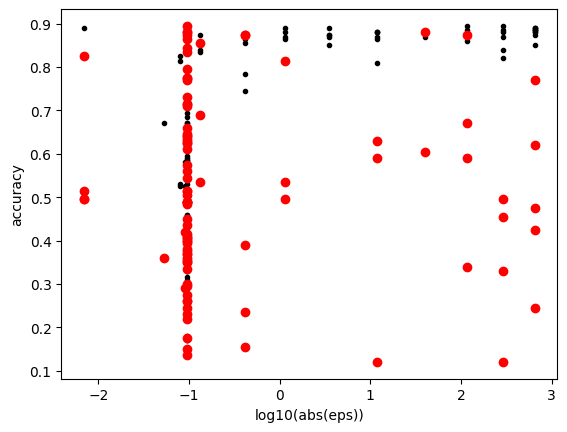

In [35]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
m = []
with open('/content/drive/MyDrive/my_variables.pkl', 'rb') as f:
    measured_points, epsilon_, accuracy_ = pickle.load(f)

with open('/content/drive/MyDrive/my_variables_LR.pkl', 'rb') as f:
    measured_points2, epsilon2_, accuracy2_ = pickle.load(f)

plt.figure()
plt.plot(np.log10(np.asarray(np.abs(epsilon_))), np.asarray(accuracy_), 'k.')
plt.plot(np.log10(np.asarray(np.abs(epsilon2_))), np.asarray(accuracy2_), 'ro')
plt.xlabel('log10(abs(eps))')
plt.ylabel('accuracy')